In [1]:
import pandas as pd
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import time
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
sns.set(style='whitegrid',palette='pastel')
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
# !pip install nltk

# Import and Do More Cleaning

In [2]:
df=pd.read_csv('merged_final_07172019.csv',thousands=',')

In [3]:
df=df.drop(columns=['raised','goal'])

In [4]:
df.head(3)

,Unnamed: 0,link,location,summary,title,created_date,tag,state,goal_int,raised_int
0,0,https://www.gofundme.com/steven-crowder-live-a...,"Dallas, TX",SMU College Republicans is bringing comedian S...,Steven Crowder Live at SMU!,"Created March 7, 2018",rep,TX,6500.0,2710.0
1,1,https://www.gofundme.com/reopen-a-nc-republica...,"Brookline, MA",NOTE: We reached our goal and then some in les...,Dems help reopen a NC Repub office,"Created October 16, 2016",rep,MA,10000.0,12857.0
2,2,https://www.gofundme.com/troopersanchez,"Mcallen, TX","￼ Moises Sanchez, a Texas State Trooper, was s...",Funds for Trooper Moises Sanchez,"Created April 7, 2019",rep,TX,20000.0,13021.0


In [5]:
#getting a look at how many campaigns with word "democrat" vs "republican"
df.tag.value_counts()

rep    864
dem    850
Name: tag, dtype: int64

In [6]:
#overlap count
df.link.value_counts()[df.link.value_counts()==2].count()

254

In [7]:
#converting dates
df['created_date']=df.created_date.str.replace('Created ','')

# df['date']=pd.to_datetime(df.created_date,infer_datetime_format=True)

In [8]:
#you'll have to drop the 1 day ago, 3 days ago...
ago_df=df[df.created_date.str.contains('ago')==True]
ago_df['created_date']=ago_df.created_date.str.replace(' ago','')

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ago_df.head(3)

,Unnamed: 0,link,location,summary,title,created_date,tag,state,goal_int,raised_int
467,531,https://www.gofundme.com/defeat-the-hijackers-...,"Grand Blanc, MI",For the last seven years I have been the subje...,"Hijacking America: The Book, ExplCmte Joe4Prez",1 day,rep,MI,5000.0,51.0
670,765,https://www.gofundme.com/1planet-climate-champ...,"Alexandria, VA",The Republican Majority in the Virginia Genera...,1Planet Climate Champions Fund,6 days,rep,VA,3000.0,100.0
744,848,https://www.gofundme.com/AMassiveParadigmShift,"Boston, MA",The September 11th Attacks... put America on a...,HELP SAVE THE AMERICAN DREAM!,3 hours,rep,MA,50000000.0,0.0


In [10]:
# turn hours ago to 1 day ago
ago_df.loc[ago_df.created_date.str.contains("hour"), 'created_date']='1 day'

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
# extract the date difference
ago_df['data_diff'] = ago_df.created_date.str.extract(r'(\d+)', expand=False).astype(int)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
#since this data was grabbed 7/17 we'll have to subtract a few more days
ago_df['created_actual']=ago_df['data_diff'].apply(lambda x: pd.datetime.now().date()-timedelta(days=x+20))

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
ago_df=ago_df.drop(columns=['created_date','data_diff'])

In [14]:
ago_df=ago_df.rename(columns={'created_actual':'created_date'})

In [15]:
df=df[df.created_date.str.contains('ago')==False]

In [16]:
df=df.append(ago_df)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [17]:
#convert to datetime and add Year, Month, Weekday
df['year']=pd.to_datetime(df.created_date).dt.year
df['month']=pd.to_datetime(df.created_date).dt.month
df['weekday_name'] =pd.to_datetime(df.created_date).dt.weekday_name

In [50]:
df.to_csv('cleaned_08072019.csv',index=False)

# Using Crosstab to Compare "Democrat" vs "Republican"

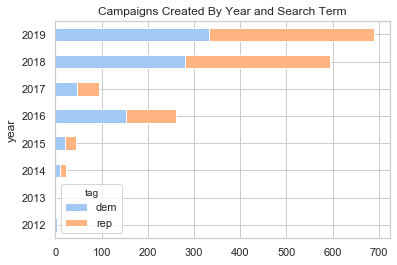

In [18]:
pd.crosstab(index=df.year,columns=df.tag).plot(kind='barh',stacked=True,title='Campaigns Created By Year and Search Term')

In [19]:
overlap=df[df.link.isin(df.link.value_counts()[df.link.value_counts()==2].index)]

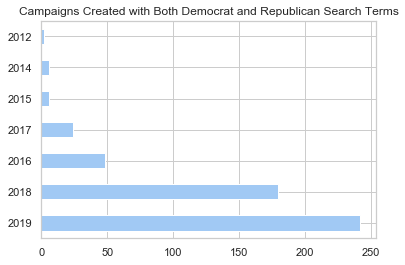

In [21]:
overlap.year.value_counts().plot(kind='barh',title='Campaigns Created with Both Democrat and Republican Search Terms')

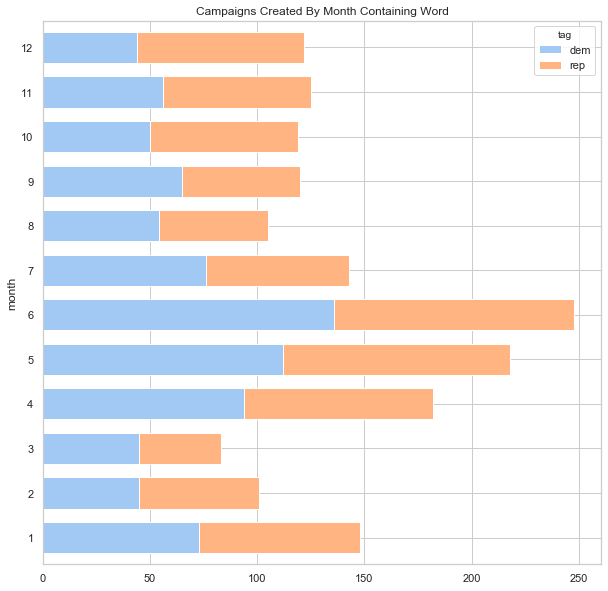

In [22]:
pd.crosstab(index=df.month,columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Month Containing Word',figsize=(10,10))

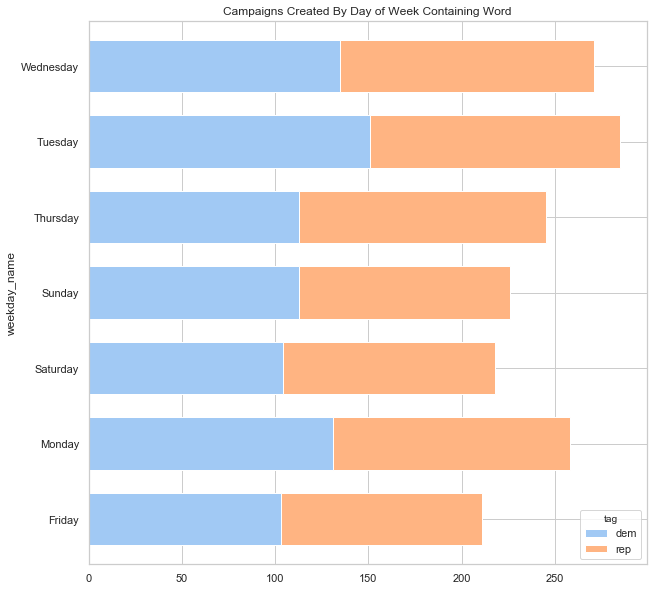

In [23]:
pd.crosstab(index=df['weekday_name'],columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Day of Week Containing Word',figsize=(10,10))

In [24]:
df.groupby('tag')['goal_int'].median()

tag
dem    5000.0
rep    9250.0
Name: goal_int, dtype: float64

In [25]:
overlap.goal_int.median()

10000.0

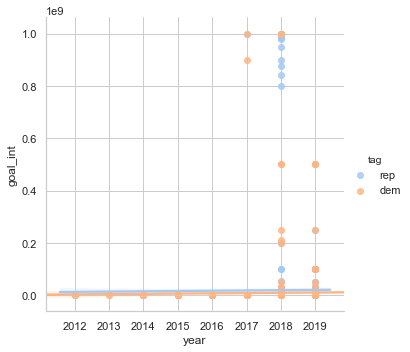

In [26]:
sns.lmplot(x='year',y='goal_int',hue='tag',data=df)

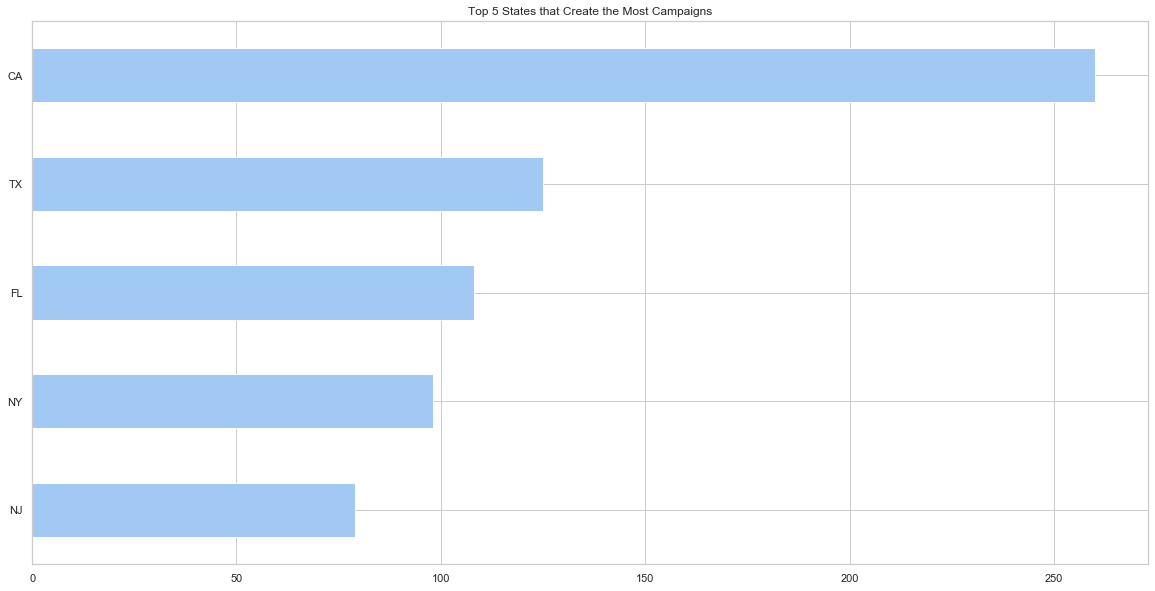

In [31]:
df.state.value_counts().sort_values(ascending=False).head(5).sort_values(ascending=True).plot(kind='barh',figsize=(20,10),title='Top 5 States that Create the Most Campaigns')

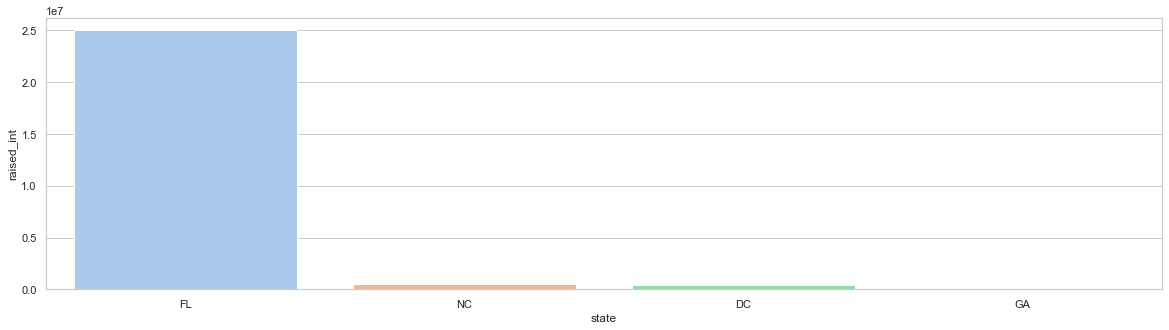

In [40]:

plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=df.sort_values(by='raised_int',ascending=False).head(5))
# plt.title('Florida Has Raised 1.2M, outpacing other state campaigns',{'fontsize': 20,'fontweight' : 1})

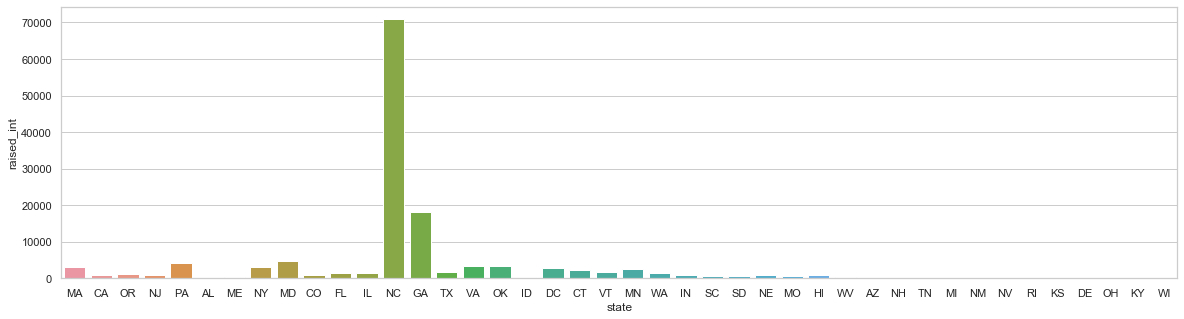

In [38]:
plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=overlap)

# Aggregate Graphs


In [249]:
# #using seaborn time series formatting
# sns.set(rc={'figure.figsize':(11, 4)})

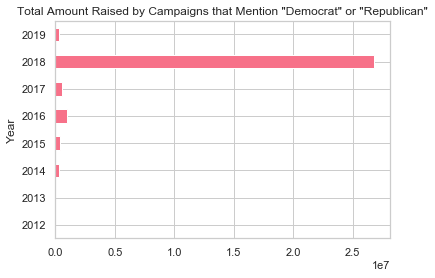

In [253]:
#total amount raised
#what is this scale though? How do I change this?
df.groupby('Year')['raised_int'].sum().plot(kind='barh',title='Total Amount Raised by Campaigns that Mention "Democrat" or "Republican"')

# plt.savefig("total_amount_raised.pdf")

In [254]:
data=pd.DataFrame(df.groupby('Year')['tag'].value_counts())

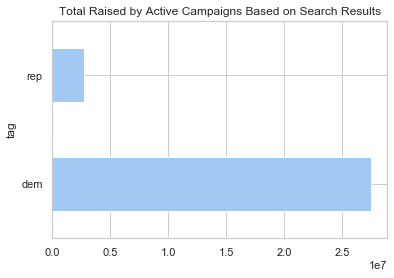

In [42]:
df.groupby('tag')['raised_int'].sum().plot(kind='barh',title='Total Raised by Active Campaigns Based on Search Results')

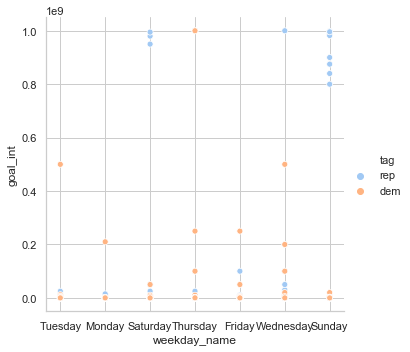

In [43]:
#the graveyard

graveyard = df[df['raised_int']==0]
sns.relplot(data=graveyard, x='weekday_name', y='goal_int', hue='tag')

In [49]:
graveyard[graveyard['weekday_name']=='Sunday'].sort_values(by='goal_int',ascending=False)

,Unnamed: 0,created_date,goal_int,link,location,raised_int,state,summary,tag,title,year,month,weekday_name
114,132,"December 30, 2018",998000000.0,https://www.gofundme.com/FundToProtectPresiden...,"Washington, DC",0.0,DC,The United States Republican Leadership Commit...,rep,Fund to protect President Trump from Indictment,2018,12,Sunday
115,133,"December 30, 2018",996000000.0,https://www.gofundme.com/FundToSupportPresiden...,"Washington, DC",0.0,DC,The United States Republican Leadership Commit...,rep,Fund to support President Trump Immigration Po...,2018,12,Sunday
110,128,"December 30, 2018",987000000.0,https://www.gofundme.com/RepublicanFundraiserT...,"Washington, DC",0.0,DC,The United States Republican Leadership Commit...,rep,Republican Fund to support the Government Shut...,2018,12,Sunday
112,130,"December 30, 2018",982000000.0,https://www.gofundme.com/RepublicanFundraiserA...,"Washington, DC",0.0,DC,After the Federal Judge says that the Obamacar...,rep,Republican Fundraiser against the Obamacare Plans,2018,12,Sunday
111,129,"December 30, 2018",900000000.0,https://www.gofundme.com/RepublicanFundraiserT...,"Washington, DC",0.0,DC,The United States Republican Leadership Commer...,rep,Republican Fundraiser to support NRA Gun Owners,2018,12,Sunday
113,131,"December 30, 2018",875000000.0,https://www.gofundme.com/FundToProtectPresiden...,"Washington, DC",0.0,DC,The United States Republican Leadership Commit...,rep,Fund to protect President Trump from Civil Law...,2018,12,Sunday
109,127,"December 30, 2018",840000000.0,https://www.gofundme.com/RepublicanFundraiserT...,"Washington, DC",0.0,DC,After the Massacre at the Marjory Stoneman Dou...,rep,Republican Fund to support the Schools Security,2018,12,Sunday
116,134,"December 30, 2018",800000000.0,https://www.gofundme.com/FundFor2020Republican...,"Washington, DC",0.0,DC,The United States Republican Leadership Commit...,rep,Fund for 2020 Republican Senatorial Candidates,2018,12,Sunday
1684,960,"April 21, 2019",20000000.0,https://www.gofundme.com/92gtc-support-trump,"Atlanta, GA",0.0,GA,President Trump is under attack The Democrat...,dem,Support Trump,2019,4,Sunday
1594,848,"July 7, 2019",5000000.0,https://www.gofundme.com/1otubio4uo,"Austin, TX",0.0,TX,I am black and I was getting off work at the w...,dem,I got Beat Up For Wearing A MAGA hat,2019,7,Sunday


# Common Words!

In [51]:
#campaigns with search result for Republican
top_N = 100000
rep_rslt =pd.DataFrame()
for index, row in df[df['tag']=='rep'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    rep_rslt=rep_rslt.append(rslt)

All frequencies, including STOPWORDS:
             Word  Frequency
0             smu          4
1              to          4
2               ,          3
3         crowder          2
4              on          2
5              at          2
6        mcfarlin          2
7               .          2
8             the          2
9         college          1
10    republicans          1
11             is          1
12       bringing          1
13       comedian          1
14         steven          1
15       thursday          1
16          march          1
17             22          1
18            7pm          1
19             in          1
20     auditorium          1
21            due          1
22             an          1
23      extremely          1
24           high          1
25         demand          1
26            see          1
27         louder          1
28           with          1
29           live          1
30             we          1
31            are          1
32   

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          4
1           the          2
2          back          2
3            we          2
4          will          2
5             ’          2
6       funding          2
7            to          2
8        events          2
9        eckerd          1
10      college          1
11  republicans          1
12          are          1
13           in          1
14       action          1
15        after          1
16           30          1
17        years          1
18            !          1
19           be          1
20    returning          1
21         this          1
22       coming          1
23       spring          1
24        2019.          1
25           re          1
26       asking          1
27            y          1
28          all          1
29          for          1
30          get          1
31         club          1
32      started          1
33           up          1
34        again  

All frequencies, including STOPWORDS:
            Word  Frequency
0              .          4
1             we          3
2            the          2
3             to          2
4       students          2
5             on          2
6         campus          2
7            and          2
8             by          2
9           csuf          1
10   republicans          1
11          seek          1
12       support          1
13  conservative          1
14             ,          1
15    empowering          1
16          them          1
17            be          1
18        active          1
19            in          1
20     community          1
21           've          1
22         faced          1
23       attacks          1
24          from          1
25       liberal          1
26       student          1
27        groups          1
28        antifa          1
29           one          1
30           our          1
31           was          1
32    physically          1
33     ass

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          3
1           to          3
2            ’          3
3           as          3
4           me          3
5            ,          2
6           my          2
7            .          2
8           ve          2
9          for          2
10       hello          1
11   everybody          1
12           !          1
13    recently          1
14     decided          1
15        come          1
16         out          1
17      family          1
18         and          1
19     friends          1
20          in          1
21     support          1
22          of          1
23   president          1
24      donald          1
25       trump          1
26         the          1
27   reactions          1
28    received          1
29   initially          1
30     started          1
31        them          1
32    ignoring          1
33          or          1
34  chastising          1
35     beliefs          1


All frequencies, including STOPWORDS:
            Word  Frequency
0              a          2
1            the          2
2             of          2
3             by          2
4              .          2
5          every          1
6              $          1
7             11          1
8           gets          1
9             my          1
10           way          1
11             (          1
12          plan          1
13             b          1
14             )          1
15          into          1
16         hands          1
17       georgia          1
18         women          1
19           who          1
20           has          1
21          been          1
22      effected          1
23        recent          1
24   legislation          1
25             i          1
26          will          1
27            be          1
28        giving          1
29         these          1
30           out          1
31       outside          1
32             “          1
33        

            Word  Frequency
0            the          4
1             at          3
2        members          3
3        student          2
4             of          2
5              .          2
6           cpac          2
7              ,          2
8        college          1
9    republicans          1
10           ucf          1
11            is          1
12             a          1
13    registered          1
14  organization          1
15    university          1
16       central          1
17       florida          1
18    consisting          1
19          100+          1
20          each          1
21          year          1
22            we          1
23          take          1
24           20+          1
25            to          1
26  conservative          1
27     political          1
28        action          1
29    conference          1
30             (          1
31             )          1
32            in          1
33      national          1
34        harbor    

          Word  Frequency
0           to          6
1            .          3
2          the          2
3           in          2
4          and          2
5         this          2
6      working          1
7       middle          1
8        class          1
9    struggles          1
10        make          1
11        ends          1
12        meet          1
13          ca          1
14          we          1
15         are          1
16       taxed          1
17   backwards          1
18    forwards          1
19        fund          1
20    programs          1
21         for          1
22       those          1
23         who          1
24          do          1
25     nothing          1
26        help          1
27  themselves          1
28          is          1
29         not          1
30      ideals          1
31      values          1
32           i          1
33        want          1
34          my          1
35    children          1
36        grow          1
37          

All frequencies, including STOPWORDS:
         Word  Frequency
0           i          2
1        hate          1
2         the          1
3  democratic          1
4       party          1
5        want          1
6          to          1
7      become          1
8           a          1
9  republican          1
All frequencies, including STOPWORDS:
           Word  Frequency
0          this          3
1        people          3
2             .          3
3            's          2
4           are          2
5           and          2
6         about          2
7            we          2
8         money          2
9            to          2
10          the          2
11    obviously          1
12       should          1
13       happen          1
14         real          1
15        lives          1
16           at          1
17        stake          1
18           it          1
19         time          1
20      started          1
21       taking          1
22       action          1
2

               Word  Frequency
0                to          5
1                 i          3
2               the          3
3               and          2
4               for          2
5         candidate          2
6                 (          2
7                 r          2
8                 )          2
9                 .          2
10               am          1
11           hoping          1
12            raise          1
13           enough          1
14              get          1
15             over          1
16            texas          1
17            knock          1
18               on          1
19            doors          1
20           senate          1
21              ted          1
22             cruz          1
23            house          1
24               of          1
25  representatives          1
26             john          1
27        culberson          1
28             want          1
29             help          1
30                ’          1
31      

          Word  Frequency
0            i          3
1           to          2
2           be          2
3            .          2
4         need          1
5            $          1
6          200          1
7      dollars          1
8       attend          1
9          the          1
10        2018          1
11        ohio          1
12  republican          1
13      dinner          1
14           ,          1
15          in          1
16       which          1
17      donald          1
18       trump          1
19        will          1
20    speaking          1
21      really          1
22        want          1
23          go          1
24         and          1
25       think          1
26        that          1
27          it          1
28       would          1
29           a          1
30        good          1
31  experience          1
All frequencies, including STOPWORDS:
           Word  Frequency
0     donations          2
1           the          2
2    republican        

         Word  Frequency
0       trump          4
1         can          2
2        lose          2
3          in          2
4         the          2
5         got          2
6           !          2
7          of          2
8       their          2
9          if          1
10        you          1
11        don          1
12          ’          1
13          t          1
14      think          1
15  president          1
16       2020          1
17   election          1
18          ,          1
19       just          1
20       look          1
21        who          1
22      voted          1
23       into          1
24     office          1
25       2018          1
26         is          1
27         it          1
28   possible          1
29       that          1
30      these          1
31        new          1
32    members          1
33    elected          1
34    because          1
35     hatred          1
36          ?          1
37         by          1
38     simply          1


          Word  Frequency
0            ,          4
1            .          3
2          the          3
3   everything          2
4        trump          2
5      touches          2
6         dies          2
7           in          2
8          one          2
9          has          2
10          of          2
11       since          1
12      moment          1
13      donald          1
14         was          1
15       sworn          1
16          as          1
17   president          1
18       thing          1
19        been          1
20       clear          1
21           ;          1
22          he          1
23        just          1
24        year          1
25         his          1
26  disastrous          1
27  presidency          1
28     already          1
29    produced          1
30           a          1
31      record          1
32     failure          1
33  corruption          1
34         and          1
35       chaos          1
36          we          1
37         '

46       spirit          1
All frequencies, including STOPWORDS:
              Word  Frequency
0               to          4
1          florida          3
2              our          3
3            right          2
4         petition          2
5            legal          2
6          defense          2
7             fund          2
8           ballot          2
9            state          2
10        citizens          1
11               [          1
12              hb          1
13               5          1
14               &          1
15      initiative          1
16            case          1
17               ]          1
18         provide          1
19         protect          1
20         approve          1
21             own          1
22  constitutional          1
23       amendment          1
24            laws          1
25              in          1
26         through          1
27            init          1
28             ...          1
All frequencies, including STOPWORD

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          4
1             .          3
2           and          2
3        health          2
4            to          2
5           the          2
6          over          2
7             a          1
8       message          1
9          from          1
10     jennifer          1
11        levin          1
12        sarah          1
13    timberman          1
14         nina          1
15      tassler          1
16       andrea          1
17   rothschild          1
18        chris          1
19       bubser          1
20            :          1
21           it          1
22            ’          1
23            s          1
24         zero          1
25         hour          1
26          for          1
27         care          1
28           in          1
29      america          1
30  republicans          1
31          are          1
32        doing          1
33   everything          1
34         they  

                   Word  Frequency
0                     #          3
1                   and          3
2                     i          2
3                  with          2
4                update          1
5                     !          1
6           freeredfawn          1
7            defunddapl          1
8              bankexit          1
9   www.freeredfawn.com          1
10   www.defunddapl.org          1
11                spent          1
12              several          1
13                weeks          1
14                    @          1
15             standing          1
16                 rock          1
17                    .          1
18            witnessed          1
19                every          1
20               moment          1
21                   on          1
22            backwater          1
23               bridge          1
24             november          1
25                 20th          1
26                  had          1
27                  

All frequencies, including STOPWORDS:
         Word  Frequency
0         has          3
1         his          3
2         dad          3
3           .          3
4           !          3
5         son          2
6       isaac          2
7          to          2
8        whom          2
9          my          1
10       been          1
11        cut          1
12        off          1
13     access          1
14          (          1
15     myself          1
16          )          1
17      loves          1
18       very          1
19       much          1
20         he          1
21     become          1
22          a          1
23       pawn          1
24         by          1
25     mother          1
26       used          1
27        him          1
28      wound          1
29     father          1
30    because          1
31        she          1
32  leverages          1
33        her          1
34        for          1
35     sexual          1
36      favor          1
37      does

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          5
1              of          4
2              to          3
3               i          2
4            have          2
5            been          2
6           state          2
7              my          1
8            name          1
9              is          1
10           marc          1
11          perez          1
12            and          1
13        elected          1
14             be          1
15            one          1
16          three          1
17      delegates          1
18             go          1
19     republican          1
20       national          1
21     convention          1
22         during          1
23           week          1
24           july          1
25           17th          1
26              -          1
27           22nd          1
28              ,          1
29   representing          1
30           10th          1
31  congressional          1
32   

                 Word  Frequency
0                   ,          8
1                 the          4
2                 one          3
3                  of          2
4            comrades          1
5                   !          1
6                   i          1
7                must          1
8               write          1
9             quickly          1
10                 as          1
11         government          1
12                 is          1
13         monitoring          1
14             public          1
15           internet          1
16           stations          1
17             hoping          1
18                for          1
19               some          1
20               sign          1
21                 me          1
22                  .          1
23              years          1
24                ago          1
25                 in          1
26            america          1
27                  ’          1
28                  s          1
29        

All frequencies, including STOPWORDS:
           Word  Frequency
0            my          2
1           and          2
2             i          2
3          have          2
4            in          2
5             .          2
6           the          2
7             a          2
8           was          2
9             ,          2
10         were          2
11        hello          1
12     patriots          1
13            !          1
14         name          1
15           is          1
16         walt          1
17        smith          1
18        lived          1
19   california          1
20       almost          1
21       entire          1
22         life          1
23          had          1
24    privilege          1
25           to          1
26         grow          1
27           up          1
28         this          1
29        state          1
30           at          1
31         time          1
32         when          1
33        there          1
34         some  

All frequencies, including STOPWORDS:
            Word  Frequency
0             in          4
1           rest          3
2            the          3
3         philly          2
4              ,          2
5             to          2
6        refugee          2
7         update          1
8              :          1
9            has          1
10      welcomed          1
11         irene          1
12            on          1
13          june          1
14            23          1
15         2017.          1
16            we          1
17           are          1
18       working          1
19          with          1
20       bethany          1
21     christian          1
22      services          1
23           try          1
24           and          1
25         bring          1
26            of          1
27           his          1
28        family          1
29       despite          1
30        recent          1
31       supreme          1
32         court          1
33        

All frequencies, including STOPWORDS:
               Word  Frequency
0                in          4
1                 ,          2
2                 .          2
3               our          1
4           dearest          1
5            friend          1
6              jane          1
7                27          1
8               y.o          1
9               was          1
10       critically          1
11          wounded          1
12               an          1
13            april          1
14             27th          1
15              car          1
16         accident          1
17         tashkent          1
18  uzbekistan.jane          1
19               is          1
20                a          1
21             coma          1
22          instant          1
23          therapy          1
24       republican          1
25         hospital          1
26             with          1
27           severe          1
28         internal          1
29            brain          1
3

          Word  Frequency
0            ,          5
1           is          4
2          her          3
3          one          2
4           of          2
5          the          2
6            .          2
7          she          2
8           to          2
9           my          1
10        wife          1
11         and          1
12        best          1
13      friend          1
14     heather          1
15        most          1
16   beautiful          1
17         fun          1
18      loving          1
19      people          1
20           i          1
21        know          1
22        many          1
23   wonderful          1
24      things          1
25         but          1
26      mostly          1
27           a          1
28      person          1
29        that          1
30   extremely          1
31  passionate          1
32       about          1
33        kids          1
34  especially          1
35       quest          1
36        have          1
37    childr

All frequencies, including STOPWORDS:
           Word  Frequency
0             i          3
1            to          3
2          that          3
3           the          3
4      national          2
5   credentials          2
6     committee          2
7            of          2
8        fellow          1
9       lefties          1
10            /          1
11      friends          1
12            ,          1
13           am          1
14      excited          1
15     announce          1
16          was          1
17      elected          1
18   democratic          1
19   convention          1
20            -          1
21          one          1
22        three          1
23     colorado          1
24      members          1
25           on          1
26            !          1
27       intend          1
28       ensure          1
29          all          1
30       issues          1
31          are          1
32     resolved          1
33           in          1
34            a  

All frequencies, including STOPWORDS:
             Word  Frequency
0               ,          6
1              to          2
2             and          2
3               i          2
4           hello          1
5        everyone          1
6           thank          1
7             you          1
8             for          1
9            your          1
10      donations          1
11              .          1
12           have          1
13           been          1
14              a          1
15           yuge          1
16         bernie          1
17      supporter          1
18             in          1
19           this          1
20      political          1
21          cycle          1
22       spending          1
23      countless          1
24          hours          1
25     canvassing          1
26          phone          1
27        banking          1
28       training          1
29     volunteers          1
30        holding          1
31  informational          1
32   

         Word  Frequency
0           .          4
1           ,          4
2           a          3
3           i          2
4          to          2
5         and          2
6        help          2
7          he          2
8          it          2
9          am          1
10     devout          1
11   catholic          1
12        who          1
13      loves          1
14       pray          1
15        the          1
16     rosary          1
17     people          1
18       take          1
19       care          1
20         of          1
21         my          1
22       best          1
23     friend          1
24       24/7          1
25    because          1
26        has          1
27  alzheimer          1
28         's          1
29      other          1
30     health          1
31     issues          1
32         is          1
33         on          1
34       very          1
35    limited          1
36     income          1
37        now          1
38        our          1


             Word  Frequency
0              it          3
1               ,          3
2              to          3
3               .          3
4             the          3
5             for          2
6              we          2
7           black          2
8             men          2
9             you          1
10           have          1
11          asked          1
12            now          1
13           need          1
14           your          1
15        support          1
16           make          1
17         happen          1
18        believe          1
19           that          1
20      community          1
21            has          1
22           been          1
23       blighted          1
24            far          1
25            too          1
26           long          1
27             by          1
28    progressive          1
29           left          1
30              ’          1
31              s          1
32          going          1
33           t

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          4
1           you          3
2            if          2
3          your          2
4          name          2
5           and          2
6           the          2
7       comment          2
8         ***we          1
9           can          1
10          win          1
11         with          1
12         this          1
13  strategy***          1
14            [          1
15         note          1
16            :          1
17          per          1
18          fec          1
19  regulations          1
20          are          1
21     donating          1
22         over          1
23            $          1
24          200          1
25         must          1
26      include          1
27         home          1
28      address          1
29     employer          1
30   occupation          1
31           in          1
32      section          1
33            .          1
34      private  

All frequencies, including STOPWORDS:
              Word  Frequency
0                ,          7
1               is          3
2              the          3
3                .          3
4               to          2
5       convention          2
6              his          2
7              for          2
8            ryder          1
9             haag          1
10             one          1
11              of          1
12        youngest          1
13        national          1
14       delegates          1
15      republican          1
16          energy          1
17       knowledge          1
18         passion          1
19             and          1
20      patriotism          1
21          truely          1
22   extraordinary          1
23               i          1
24        victoria          1
25        crockett          1
26              am          1
27         helping          1
28           raise          1
29           funds          1
30               (          1
31

All frequencies, including STOPWORDS:
             Word  Frequency
0               .          3
1               i          3
2               ,          3
3              am          2
4               a          2
5    installation          2
6             and          2
7              to          2
8              my          1
9            name          1
10             is          1
11         terese          1
12          agnew          1
13             an          1
14         artist          1
15       creating          1
16          large          1
17          scale          1
18  collaborative          1
19            art          1
20           that          1
21         honors          1
22      wisconsin          1
23             's          1
24       historic          1
25       cultural          1
26        natural          1
27         assets          1
28        raising          1
29          money          1
30          build          1
31     sculptural          1
32   

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          5
1            ,          4
2           my          3
3           in          3
4            .          2
5           am          2
6           to          2
7           of          2
8           hi          1
9         name          1
10          is          1
11       jason          1
12      chavez          1
13        from          1
14      tucson          1
15     arizona          1
16         and          1
17   currently          1
18        live          1
19    richmond          1
20    virginia          1
21       where          1
22           a          1
23     student          1
24          at          1
25        john          1
26       tyler          1
27   community          1
28     college          1
29      expect          1
30    graduate          1
31        with          1
32   associate          1
33     science          1
34      degree          1
35     general          1


            Word  Frequency
0             of          3
1             my          2
2            and          2
3              i          2
4             am          2
5            the          2
6        college          2
7             in          2
8             as          2
9             hi          1
10      everyone          1
11             !          1
12          name          1
13            is          1
14         sarah          1
15        gibson          1
16       current          1
17         first          1
18          vice          1
19      chairman          1
20       florida          1
21    federation          1
22   republicans          1
23             .          1
24          also          1
25        senior          1
26          year          1
27            at          1
28           ucf          1
29      studying          1
30     political          1
31       science          1
32       pre-law          1
33          with          1
34        minors    

          Word  Frequency
0            a          5
1          the          4
2            .          3
3       engine          3
4          for          2
5           in          2
6          and          2
7           it          2
8           we          2
9         have          2
10    tazewell          1
11      county          1
12  republican          1
13       party          1
14         has          1
15         had          1
16        1950          1
17        fire          1
18       truck          1
19         use          1
20     parades          1
21     special          1
22      events          1
23         was          1
24        even          1
25        used          1
26     wedding          1
27         few          1
28       years          1
29         ago          1
30    recently          1
31        blew          1
32         rod          1
33          is          1
34     broke.s          1
35      person          1
36         who          1
37        wi

All frequencies, including STOPWORDS:
              Word  Frequency
0               to          3
1                ,          3
2              the          2
3           meyers          2
4              for          2
5         congress          2
6                .          2
7              let          1
8               's          1
9             send          1
10               a          1
11  constitutional          1
12    conservative          1
13      washington          1
14              dc          1
15               !          1
16        campaign          1
17           needs          1
18         funding          1
19             get          1
20              us          1
21         through          1
22      republican          1
23      convention          1
24              on          1
25           april          1
26            26th          1
27          donate          1
28             now          1
29            help          1
30            with          1
31

                                           Word  Frequency
0                                             !          3
1                                          note          2
2                                            to          2
3                                             :          2
4                                          your          2
5                                            in          2
6                                           you          2
7                                           now          2
8                                      donaters          1
9                                        please          1
10                                        leave          1
11                                        email          1
12                                            a          1
13                                         with          1
14                                     donation          1
15                                           so         

         Word  Frequency
0          we          5
1          to          3
2          of          3
3           .          3
4        want          2
5        help          2
6         the          2
7       trump          2
8         are          2
9         but          2
10         as          2
11        any          2
12         be          1
13      apart          1
14      wagon          1
15          ?          1
16       here          1
17         is          1
18       your          1
19     chance          1
20          !          1
21       this          1
22    weekend          1
23    filming          1
24          a          1
25      video          1
26    promote          1
27  president          1
28     donald          1
29       have          1
30    covered          1
31       most          1
32   expenses          1
33  ourselves          1
34      still          1
35    lacking          1
36    funding          1
37    involve          1
38       many          1


All frequencies, including STOPWORDS:
           Word  Frequency
0           the          3
1         women          3
2            to          3
3            's          2
4      campaign          2
5        school          2
6             .          2
7            hi          1
8      everyone          1
9             !          1
10           my          1
11         name          1
12           is          1
13         rita          1
14    francesca          1
15     loffredo          1
16          and          1
17            i          1
18          was          1
19     recently          1
20     accepted          1
21         into          1
22           at          1
23         yale          1
24         this          1
25  prestigious          1
26      program          1
27        works          1
28      prepare          1
29          who          1
30       intend          1
31          run          1
32          for          1
33       office          1
34           or  

All frequencies, including STOPWORDS:
            Word  Frequency
0            the          5
1             to          4
2              ,          2
3             is          2
4              .          2
5         during          1
6            our          1
7       national          1
8           roll          1
9            out          1
10            we          1
11          want          1
12      continue          1
13            do          1
14     following          1
15             :          1
16            1.          1
17          keep          1
18    production          1
19            in          1
20           usa          1
21            2.          1
22      maintain          1
23          free          1
24      shipping          1
25          goal          1
26           get          1
27            as          1
28          many          1
29         games          1
30      everyone          1
31        before          1
32      midterms          1
33        

All frequencies, including STOPWORDS:
            Word  Frequency
0            the          7
1             of          4
2    declaration          3
3           this          2
4       governed          2
5          group          1
6             is          1
7      dedicated          1
8        towards          1
9      signature          1
10         drive          1
11           for          1
12            ``          1
13            ''          1
14      petition          1
15           and          1
16     providing          1
17   information          1
18         about          1
19       consent          1
20             -          1
21          rock          1
22          your          1
23        rights          1
24       america          1
25          tour          1
26             .          1
27           was          1
28       written          1
29         using          1
30      language          1
31      original          1
32  independence          1
33        

All frequencies, including STOPWORDS:
       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
            Word  Frequency
0             to          7
1              !          2
2             is          2
3             it          2
4              a          2
5           make          2
6              i          2
7            hey          1
8       everyone          1
9             my          1
10          name          1
11        amanda          1
12           and          1
13           has          1
14          been          1
15           big          1
16          goal          1
17            of          1
18          mine          1
19        change          1
20            in          1
21        people          1
22             ’          1
23             s          1
24         lives          1
25             .          1
26            am          1
27          more          1
28          than    

            Word  Frequency
0            the          3
1             in          3
2             of          2
3    immigration          2
4              a          2
5        problem          2
6              .          2
7     regardless          1
8          where          1
9            you          1
10         stand          1
11            on          1
12        policy          1
13         first          1
14          step          1
15       solving          1
16            is          1
17        having          1
18       serious          1
19           and          1
20   transparent          1
21  conversation          1
22            at          1
23         which          1
24           one          1
25          aims          1
26            to          1
27       address          1
28          over          1
29         three          1
30          past          1
31         years          1
32             ,          1
33            we          1
34          have    

           Word  Frequency
0             ,          7
1             i          4
2             a          3
3            am          3
4           and          3
5             .          3
6         build          2
7        border          2
8          wall          2
9        around          2
10        trump          2
11           an          1
12       artist          1
13     activist          1
14     academic          1
15        queer          1
16        brown          1
17    nonbinary          1
18         also          1
19         kind          1
20           of          1
21          hot          1
22         have          1
23       dimple          1
24           in          1
25           my          1
26         chin          1
27         want          1
28           to          1
29      because          1
30          you          1
31         know          1
32       racism          1
33  incompetent          1
34      corrupt          1
35   politician          1
3

All frequencies, including STOPWORDS:
             Word  Frequency
0               .          3
1               i          3
2               a          3
3              my          3
4              to          2
5             the          2
6               !          2
7           stuff          2
8        ￼￼￼￼￼￼￼￼          1
9              hi          1
10           this          1
11             is          1
12          scott          1
13            had          1
14         little          1
15           help          1
16             wk          1
17            ago          1
18         trying          1
19            set          1
20             up          1
21           page          1
22  unfortunately          1
23             he          1
24          never          1
25           came          1
26           back          1
27           next          1
28            day          1
29            add          1
30          story          1
31             'm          1
32   

           Word  Frequency
0             i          5
1             ,          4
2            to          4
3           and          4
4            am          3
5         leave          3
6             .          3
7           you          2
8          will          2
9           the          2
10     mid-term          2
11    elections          2
12         dear          1
13  republicans          1
14        tired          1
15           of          1
16         what          1
17         have          1
18         done          1
19          our          1
20      country          1
21      willing          1
22       unlike          1
23          all          1
24        those          1
25     liberals          1
26          who          1
27     promised          1
28       before          1
29           if          1
30         send          1
31           me          1
32         away          1
33           go          1
34         move          1
35       europe          1
3

            Word  Frequency
0             to          3
1            our          2
2          start          2
3       building          2
4         modern          2
5              .          2
6            and          2
7          using          1
8            top          1
9     technology          1
10     resources          1
11             a          1
12           day          1
13  civilization          1
14           off          1
15           the          1
16         grind          1
17          self          1
18    sustaining          1
19      starting          1
20          from          1
21  distributing          1
22         solar          1
23        panels          1
24           low          1
25      resource          1
26     countries          1
27    affordable          1
28     temporary          1
29       housing          1
30           for          1
31       college          1
32      students          1
33       natural          1
34     disasters    

All frequencies, including STOPWORDS:
            Word  Frequency
0             my          4
1              i          3
2             of          3
3            and          3
4              .          3
5             in          2
6            the          2
7           life          2
8              ,          2
9         degree          2
10            am          2
11          have          1
12             a          1
13       passion          1
14           for          1
15     assisting          1
16        others          1
17          some          1
18        lowest          1
19       highest          1
20        points          1
21         their          1
22      spending          1
23      majority          1
24            on          1
25       working          1
26    furthering          1
27     education          1
28       proudly          1
29     obtaining          1
30       nursing          1
31         still          1
32        driven          1
33        

All frequencies, including STOPWORDS:
            Word  Frequency
0             of          4
1            the          4
2             is          3
3             we          2
4         dallas          2
5              .          2
6            are          1
7              a          1
8   conservative          1
9              -          1
10             >          1
11      moderate          1
12    republican          1
13         group          1
14     community          1
15    organizers          1
16           and          1
17           our          1
18          goal          1
19      creation          1
20           two          1
21   initiatives          1
22         first          1
23   replacement          1
24        robert          1
25             e          1
26           lee          1
27       statute          1
28          that          1
29           was          1
30            on          1
31        turtle          1
32         creek          1
33        

          Word  Frequency
0            .          5
1           to          3
2            i          3
3            a          3
4           am          2
5           ``          2
6           ''          2
7           me          2
8           's          2
9    according          1
10  mainstream          1
11       media          1
12  classified          1
13          as          1
14  deplorable          1
15       trump          1
16      loving          1
17  republican          1
18      living          1
19          in          1
20         the          1
21  democratic          1
22        hell          1
23        that          1
24          is          1
25  california          1
26          do          1
27         not          1
28        feel          1
29        safe          1
30     wearing          1
31          my          1
32        make          1
33     america          1
34       great          1
35       again          1
36         hat          1
37        he

            Word  Frequency
0             to          2
1    republicans          1
2          would          1
3         prefer          1
4           live          1
5             in          1
6          their          1
7            own          1
8        society          1
9            and          1
10             i          1
11            am          1
12  volunteering          1
13         leave          1
14             .          1
All frequencies, including STOPWORDS:
           Word  Frequency
0           the          9
1            of          5
2        voices          2
3           and          2
4    right-side          1
5          view          1
6        spirit          1
7           man          1
8       looking          1
9       through          1
10         your          1
11         eyes          1
12            !          1
13        peace          1
14           is          1
15         with          1
16         both          1
17      parties          1
1

All frequencies, including STOPWORDS:
           Word  Frequency
0           and          4
1           the          3
2            is          2
3             .          2
4             ,          2
5          they          2
6            hi          1
7            my          1
8          name          1
9          rick          1
10            i          1
11         will          1
12          get          1
13           to          1
14        point          1
15          our          1
16    democracy          1
17           in          1
18      trouble          1
19           by          1
20         both          1
21      parties          1
22    democrats          1
23  republicans          1
24           as          1
25       should          1
26           be          1
27      working          1
28           on          1
29   healthcare          1
30       reform          1
31       border          1
32     policies          1
33          are          1
34           up  

                            Word  Frequency
0                             we          6
1                            the          4
2                              .          4
3                            and          3
4                            are          3
5                              ,          2
6                            can          2
7                           hear          1
8                            how          1
9                            bad          1
10                      terrible          1
11                         trump          1
12                            's          1
13                    republican          1
14                      policies          1
15                          left          1
16                          with          1
17                       feeling          1
18                      helpless          1
19                           but          1
20                           not          1
21                         there

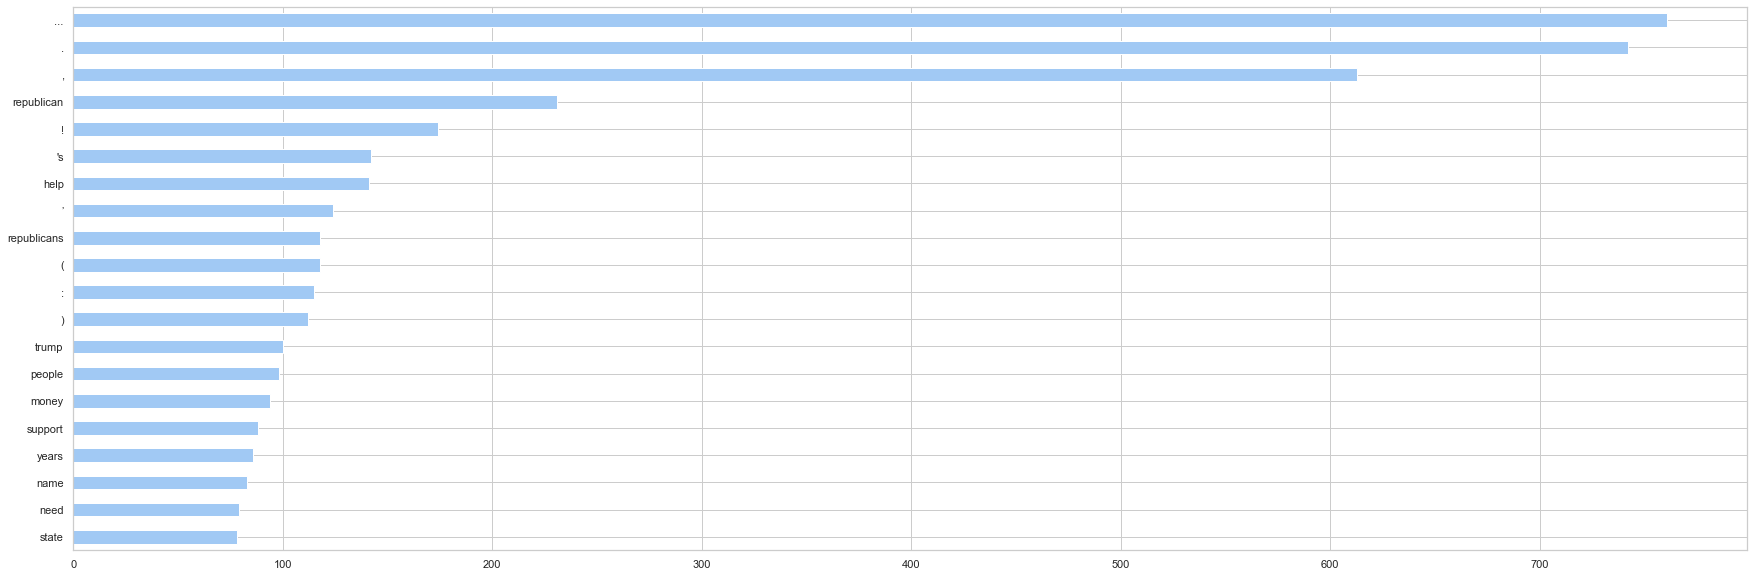

In [52]:
rep_rslt.index.value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(30,10))

In [222]:
# rep_rslt['count'] =1
# rep_rslt=rep_rslt.groupby('Word').agg({'count':'sum'})


In [243]:
rep_counts=pd.DataFrame(rep_rslt.index.value_counts()).reset_index()


In [245]:
rep_counts['wd_pct']=rep_counts['Word']/864

In [246]:
rep_counts.sort_values('wd_pct',ascending=False)

,index,Word,wd_pct
0,...,761,0.868721
1,.,742,0.847032
2,",",613,0.699772
3,republican,231,0.263699
4,!,174,0.198630
5,'s,142,0.162100
6,help,141,0.160959
7,’,124,0.141553
8,republicans,118,0.134703
9,(,118,0.134703


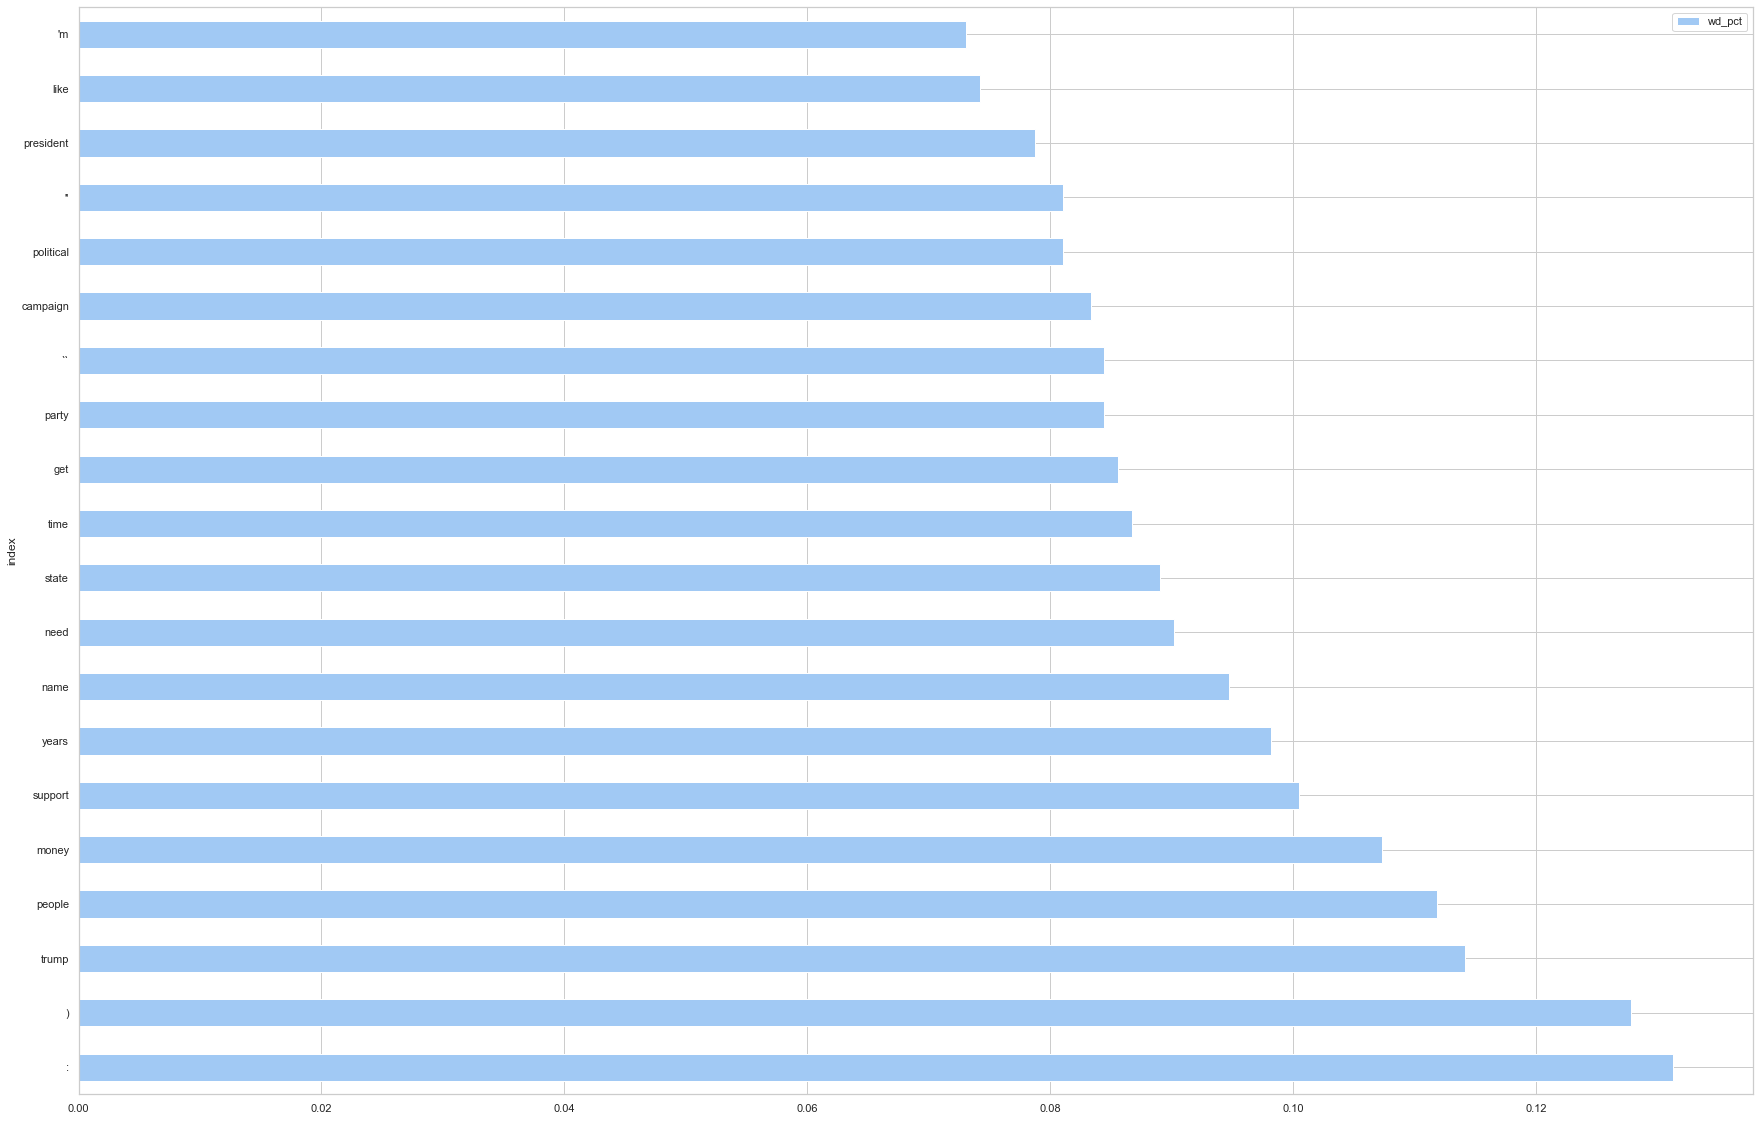

In [249]:
rep_counts.sort_values('wd_pct',ascending=False)[10:30].plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

In [250]:
#campaigns with the word democrat
top_N = 100000
dem_rslt =pd.DataFrame()
for index, row in df[df['tag']=='dem'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    dem_rslt=dem_rslt.append(rslt)

All frequencies, including STOPWORDS:
                    Word  Frequency
0                     to          3
1                    the          3
2                     in          2
3                     we          2
4                   have          2
5                  raise          2
6                      a          2
7                  print          1
8                vaccine          1
9                 safety          1
10             statement          1
11                  with          1
12                   all          1
13                   our          1
14                 names          1
15                beside          1
16                    it          1
17                 press          1
18              democrat          1
19                     $          1
20                 2,268          1
21                   for          1
22                  half          1
23                  page          1
24         advertisement          1
25                     .  

           Word  Frequency
0            to          5
1            we          4
2            in          4
3          help          3
4             .          3
5          need          2
6             a          2
7      november          2
8           the          2
9          your          1
10         fund          1
11        video          1
12      project          1
13    democrats          1
14          win          1
15        young          1
16         team          1
17           of          1
18  progressive          1
19          and          1
20     democrat          1
21   volunteers          1
22           is          1
23       coming          1
24     together          1
25        elect          1
26   candidates          1
27     kootenai          1
28       county          1
29         feel          1
30         that          1
31        order          1
32       really          1
33          get          1
34          out          1
35         vote          1
3

All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          5
1            the          3
2             on          2
3             to          2
4          close          2
5             up          2
6              !          2
7             we          2
8           will          2
9       students          1
10            of          1
11       esparto          1
12          high          1
13        school          1
14           are          1
15     traveling          1
16             a          1
17           fun          1
18           and          1
19   educational          1
20          trip          1
21    washington          1
22            dc          1
23          with          1
24    foundation          1
25        nation          1
26             ’          1
27             s          1
28       leading          1
29    non-profit          1
30  non-partisan          1
31         civic          1
32     education          1
33  organi

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          5
1          new          4
2         york          4
3        state          4
4        young          4
5           of          3
6    democrats          3
7          for          2
8            a          2
9            .          2
10       thank          1
11         you          1
12          so          1
13        much          1
14     helping          1
15        make          1
16          my          1
17       dream          1
18       being          1
19    delegate          1
20    democrat          1
21           ’          1
22           s          1
23     reality          1
24         are          1
25    official          1
26       youth          1
27         arm          1
28  democratic          1
29   committee          1
30   represent          1
31     between          1
32        ages          1
33         ...          1
All frequencies, including STOPWORDS:
            Wo

            Word  Frequency
0              .          3
1             to          3
2             is          2
3      democrats          2
4            the          2
5             my          1
6           name          1
7             es          1
8        .making          1
9       disabled          1
10          feel          1
11         proud          1
12         right          1
13            be          1
14       counted          1
15           .my          1
16          goal          1
17          make          1
18          sure          1
19  disadvantage          1
20         .have          1
21          ride          1
22          vote          1
23             !          1
All frequencies, including STOPWORDS:
     Word  Frequency
0      to          1
1  defeat          1
2      ro          1
3  khanna          1
4       .          1
All frequencies, including STOPWORDS:
         Word  Frequency
0          to          4
1         for          2
2           .          

            Word  Frequency
0             in          3
1            ccd          2
2            the          2
3              .          2
4           have          2
5            and          2
6              ,          2
7        citadel          1
8        college          1
9      democrats          1
10             (          1
11             )          1
12            is          1
13           its          1
14         first          1
15          year          1
16            of          1
17     existence          1
18           but          1
19           has          1
20          made          1
21             a          1
22          huge          1
23        impact          1
24     community          1
25            we          1
26        logged          1
27         close          1
28            to          1
29           100          1
30         hours          1
31       working          1
32            on          1
33         state          1
34       federal    

             Word  Frequency
0              to          4
1       president          1
2           trump          1
3           needs          1
4              be          1
5      re-elected          1
6             and          1
7   organizations          1
8            like          1
9            this          1
10           need          1
11          funds          1
12            get          1
13           word          1
14            out          1
15              .          1
16         please          1
17           help          1
All frequencies, including STOPWORDS:
           Word  Frequency
0           the          2
1             i          1
2            am          1
3       raising          1
4         money          1
5            to          1
6        defeat          1
7   republicans          1
8            so          1
9            us          1
10    democrats          1
11          can          1
12         gain          1
13      control          1
14    

           Word  Frequency
0           all          4
1             ?          3
2     donations          3
3             ,          3
4             $          2
5             =          2
6           and          2
7         while          2
8           the          2
9     community          2
10            .          2
11     democrat          1
12           vs          1
13   republican          1
14            -          1
15          who          1
16        helps          1
17         more          1
18          odd          1
19  republicans          1
20         even          1
21    democrats          1
22          let          1
23       settle          1
24         this          1
25       debate          1
26         once          1
27          for          1
28      helping          1
29          out          1
30         will          1
31           go          1
32           to          1
33       people          1
34      animals          1
35    charities          1
3

           Word  Frequency
0           the          5
1            of          4
2            to          2
3             ,          2
4       purpose          1
5          this          1
6          fund          1
7         drive          1
8            is          1
9     establish          1
10            a          1
11    political          1
12       action          1
13    committee          1
14       tasked          1
15         with          1
16   recruiting          1
17  fundraising          1
18          and          1
19      general          1
20      support          1
21     centrist          1
22   democratic          1
23   candidates          1
24           in          1
25        inner          1
26       cities          1
27       across          1
28       united          1
29       states          1
30            .          1
31   monolithic          1
32      control          1
33        black          1
34         vote          1
35          has          1
3

52        ...          1
All frequencies, including STOPWORDS:
         Word  Frequency
0         the          4
1           ,          4
2         and          3
3           .          3
4          my          2
5           i          2
6        with          2
7      blekic          2
8      family          2
9          in          2
10       that          2
11        you          2
12         to          2
13       name          1
14         is          1
15      angie          1
16   filipsic          1
17         am          1
18    friends          1
19       boys          1
20     attend          1
21       high          1
22     school          1
23     medina          1
24        are          1
25     njrotc          1
26   together          1
27       here          1
28        st.          1
29  augustine          1
30         fl          1
31        ask          1
32       read          1
33      story          1
34      below          1
35         if          1
36        ca

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          5
1           the          3
2           and          3
3           for          2
4            in          2
5             .          2
6            we          2
7          yale          1
8       college          1
9     democrats          1
10          are          1
11  intentional          1
12    advocates          1
13  progressive          1
14       change          1
15          new          1
16        haven          1
17  connecticut          1
18       across          1
19      country          1
20        fight          1
21   candidates          1
22       causes          1
23         that          1
24      advance          1
25        equal          1
26      justice          1
27        human          1
28      dignity          1
29  empowerment          1
30           of          1
31          all          1
32       people          1
33        while          1
34    resisting  

                   Word  Frequency
0                     :          5
1                     ,          4
2                   the          2
3                   our          2
4                    to          2
5                    my          2
6                  2018          1
7             elections          1
8                   are          1
9                  most          1
10            important          1
11             midterms          1
12                   of          1
13             lifetime          1
14                    .          1
15               donate          1
16                    #          1
17  grassrootsisgreener          1
18                 tour          1
19              support          1
20            volunteer          1
21                 work          1
22             electing          1
23            democrats          1
24               across          1
25              country          1
26          albuquerque          1
27                  

              Word  Frequency
0              and          3
1               to          2
2                a          2
3   accountability          1
4               pa          1
5               is          1
6               an          1
7    all-volunteer          1
8         feminist          1
9       collective          1
10       committed          1
11         holding          1
12         elected          1
13           party          1
14       officials          1
15     accountable          1
16             for          1
17          sexual          1
18      misconduct          1
19        violence          1
20               .          1
21              we          1
22            came          1
23        together          1
24              in          1
25            2018          1
26          demand          1
27           state          1
28         senator          1
29          daylin          1
30           leach          1
31              's          1
32     res

             Word  Frequency
0               a          5
1               .          4
2               i          3
3              my          2
4              is          2
5              am          2
6             the          2
7              of          2
8              in          2
9             and          2
10          hello          1
11           name          1
12       chastity          1
13          abney          1
14         rising          1
15         senior          1
16             at          1
17     university          1
18          south          1
19       carolina          1
20          aiken          1
21          major          1
22      political          1
23        science          1
24           with          1
25  concentration          1
26        pre-law          1
27          minor          1
28       criminal          1
29        justice          1
30      currently          1
31        serving          1
32             as          1
33         mem

All frequencies, including STOPWORDS:
             Word  Frequency
0             and          3
1              to          3
2               ,          3
3               a          2
4             the          2
5            post          2
6            cafe          2
7            have          2
8               .          2
9             our          2
10            for          2
11           many          2
12             we          1
13           were          1
14        shocked          1
15       saddened          1
16             as          1
17      community          1
18          today          1
19            see          1
20      following          1
21           from          1
22         nicole          1
23        mccoomb          1
24          owner          1
25             of          1
26        madison          1
27             's          1
28              :          1
29             ``          1
30           this          1
31             is          1
32   

All frequencies, including STOPWORDS:
          Word  Frequency
0           we          3
1            ,          3
2           to          3
3            !          2
4          the          2
5            .          2
6           us          2
7          and          2
8     facebook          2
9          has          2
10        ￼￼￼￼          1
11         hey          1
12        guys          1
13          do          1
14         not          1
15     receive          1
16    millions          1
17        from          1
18  government          1
19      george          1
20       soros          1
21          or          1
22     silicon          1
23      valley          1
24         are          1
25   supported          1
26          by          1
27         you          1
28      people          1
29        here          1
30          at          1
31   'lgbtrump          1
32           -          1
33        gays          1
34         for          1
35       trump          1


            Word  Frequency
0             to          4
1              a          3
2            the          3
3              ,          2
4            and          2
5             by          2
6             hi          1
7       everyone          1
8              !          1
9             in          1
10      response          1
11        recent          1
12    outrageous          1
13     political          1
14        events          1
15      continue          1
16         build          1
17      movement          1
18        fueled          1
19     kavanaugh          1
20  confirmation          1
21            we          1
22         would          1
23          love          1
24       release          1
25         music          1
26         video          1
27          that          1
28     expresses          1
29          both          1
30   frustration          1
31   empowerment          1
32            of          1
33         women          1
34         today    

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          4
1            ,          4
2         fire          3
3            a          3
4   bloomsbury          2
5           to          2
6            .          2
7     extended          2
8           of          2
9           on          1
10    november          1
11        28th          1
12          at          1
13         9pm          1
14     company          1
15       along          1
16        with          1
17    multiple          1
18    agencies          1
19   responded          1
20        that          1
21      ripped          1
22     through          1
23      duplex          1
24         had          1
25        only          1
26         one          1
27        half          1
28       house          1
29         but          1
30   destroyed          1
31       great          1
32      amount          1
33  belongings          1
34     fulpers          1
35   including          1


All frequencies, including STOPWORDS:
             Word  Frequency
0             the          5
1               !          3
2          dekalb          2
3              to          2
4        dunwoody          2
5            july          2
6             4th          2
7          parade          2
8              in          2
9               a          2
10         please          1
11           help          1
12           send          1
13           dems          1
14            for          1
15           last          1
16            two          1
17          years          1
18              ,          1
19      democrats          1
20          house          1
21       district          1
22             79          1
23           have          1
24            had          1
25      wonderful          1
26           time          1
27  participating          1
28              ’          1
29              s          1
30              .          1
31             it          1
32   

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          8
1            my          5
2           the          4
3             i          3
4           and          3
5           ...          3
6         cause          2
7            is          2
8           for          2
9    resistance          1
10         what          1
11         live          1
12            .          1
13      current          1
14        focus          1
15         much          1
16         like          1
17        yours          1
18      imagine          1
19      driving          1
20          out          1
21   malevolent          1
22  trump/pence          1
23       regime          1
24       ethics          1
25   conscience          1
26         love          1
27     humanity          1
28       demand          1
29     dedicate          1
30         full          1
31     strength          1
32           of          1
33    abilities          1
34      passion  

                     Word  Frequency
0                       i          4
1                       a          3
2                      to          3
3                  bernie          3
4                       .          3
5                     was          2
6                 elected          2
7                 sanders          2
8                     the          2
9                    utah          2
10                     's          2
11                     as          1
12               national          1
13               delegate          1
14                   cast          1
15                   vote          1
16                    for          1
17                   this          1
18                 summer          1
19                     at          1
20             democratic          1
21             convention          1
22                     am          1
23               activist          1
24                     in          1
25                 verify          1
2

All frequencies, including STOPWORDS:
                                                 Word  Frequency
0                                                   !          3
1                                                help          2
2                                                  is          2
3                                                http          1
4                                                   :          1
5   //www.appeal-democrat.com/news/brownsville-man...          1
6                                              please          1
7                                                 any          1
8                                            donation          1
9                                              amount          1
10                                            greatly          1
11                                        appreciated          1
12                                                the          1
13                                             prune

All frequencies, including STOPWORDS:
            Word  Frequency
0             is          6
1              .          5
2            rob          4
3            the          4
4            and          2
5              a          2
6             he          2
7          party          2
8             my          1
9           name          1
10         erica          1
11             i          1
12            am          1
13       sighted          1
14         guide          1
15           for          1
16        kerney          1
17           was          1
18       elected          1
19            by          1
20           his          1
21            to          1
22        attend          1
23           dnc          1
24          2016          1
25            in          1
26  philadelphia          1
27          only          1
28      delegate          1
29          from          1
30       indiana          1
31           who          1
32       totally          1
33        

          Word  Frequency
0            i          4
1          was          2
2           to          2
3      senator          2
4          the          2
5            .          2
6           in          2
7           hi          1
8            ,          1
9           my          1
10        name          1
11          is          1
12      hannah          1
13  wroblewski          1
14         and          1
15     elected          1
16          as          1
17           a          1
18        2016          1
19        pleo          1
20    national          1
21    delegate          1
22     pledged          1
23      bernie          1
24     sanders          1
25        from          1
26       great          1
27       state          1
28          of          1
29    nebraska          1
30     started          1
31     getting          1
32    involved          1
33    politics          1
34       while          1
35        high          1
36      school          1
37       whe

All frequencies, including STOPWORDS:
           Word  Frequency
0             !          4
1             ,          3
2            to          3
3           all          2
4           the          2
5    convention          2
6             .          2
7          cost          2
8           for          2
9           and          2
10         will          2
11         this          2
12            i          2
13         need          1
14          met          1
15        thank          1
16          you          1
17         send          1
18       jeanne          1
19        smith          1
20            a          1
21  transgender          1
22        woman          1
23   democratic          1
24     national          1
25           it          1
26           is          1
27    estimated          1
28         that          1
29         each          1
30     delegate          1
31        hotel          1
32       travel          1
33         food          1
34           be  

All frequencies, including STOPWORDS:
         Word  Frequency
0           ,          8
1         the          2
2          by          2
3         her          2
4         and          2
5         for          2
6        most          1
7    horrific          1
8       words          1
9         you          1
10      could          1
11       ever          1
12       hear          1
13          :          1
14       your          1
15     mother          1
16     sister          1
17       wife          1
18         or          1
19   daughter          1
20        has          1
21       been          1
22   brutally          1
23   attacked          1
24          a          1
25   predator          1
26       body          1
27  mutilated          1
28      raped          1
29   tortured          1
30       then          1
31       left          1
32       dead          1
33          .          1
34       only          1
35    posting          1
36         on          1
37   faceboo

All frequencies, including STOPWORDS:
            Word  Frequency
0            and          3
1              i          2
2           have          2
3            gun          2
4       violence          2
5              .          2
6             in          2
7            for          2
8              ,          2
9              a          2
10            my          1
11          wife          1
12   experienced          1
13           the          1
14      horrific          1
15       effects          1
16            of          1
17          2015          1
18           our          1
19      daughter          1
20        alison          1
21           was          1
22        gunned          1
23          down          1
24            on          1
25          live          1
26    television          1
27         while          1
28     reporting          1
29         wdbj7          1
30       roanoke          1
31  virginia—her          1
32          home          1
33        

           Word  Frequency
0             ,          5
1           and          4
2           you          3
3       elected          2
4           for          2
5       senator          2
6       sanders          2
7            if          2
8         needs          2
9            my          1
10         name          1
11           is          1
12        susan          1
13         soto          1
14       palmer          1
15            i          1
16          was          1
17           on          1
18         june          1
19           19          1
20         2016          1
21           as          1
22            a          1
23        party          1
24       leader          1
25     official          1
26            (          1
27         pleo          1
28            )          1
29     delegate          1
30       bernie          1
31            .          1
32      support          1
33          the          1
34    political          1
35   revolution          1
3

All frequencies, including STOPWORDS:
         Word  Frequency
0           ,          4
1          is          4
2           .          4
3          we          3
4     because          2
5          of          2
6         not          2
7          it          2
8         and          2
9          to          2
10       with          2
11        our          2
12          (          1
13        pic          1
14       from          1
15      hueco          1
16      tanks          1
17         tx          1
18          )          1
19        why          1
20       does          1
21   standing          1
22       rock          1
23     matter          1
24          ?          1
25      abuse          1
26     native          1
27  americans          1
28          a          1
29      thing          1
30    history          1
31    current          1
32      alive          1
33       ours          1
34       deal          1
35         if          1
36         do          1
37        ac

          Word  Frequency
0            ,          5
1            (          3
2     daughter          2
3           to          2
4         lost          2
5          her          2
6    apartment          2
7           in          2
8          the          2
9         fire          2
10           .          2
11           )          2
12       their          2
13      damage          2
14      nicole          1
15           –          1
16     richena          1
17     johnson          1
18         has          1
19          w.          1
20      steele          1
21        lane          1
22        last          1
23        week          1
24       nikki          1
25     husband          1
26        neal          1
27         and          1
28        abby          1
29        have          1
30         all          1
31          of          1
32  belongings          1
33         due          1
34  fire/smoke          1
35       santa          1
36        rosa          1
37   displac

All frequencies, including STOPWORDS:
             Word  Frequency
0             not          3
1              nj          2
2             gop          2
3            from          2
4               .          2
5             the          2
6            with          2
7             and          2
8              to          2
9               i          1
10             am          1
11        running          1
12            for          1
13          state          1
14      committee          1
15         hudson          1
16         county          1
17        suffers          1
18           only          1
19              a          1
20    significant          1
21            gap          1
22             in          1
23   registration          1
24      democrats          1
25            but          1
26           also          1
27              (          1
28        related          1
29              )          1
30            its          1
31      inability          1
32   

           Word  Frequency
0           for          3
1             ,          3
2             i          2
3            am          2
4            my          2
5           the          2
6    democratic          2
7      national          2
8        bernie          2
9             .          2
10           to          2
11         this          2
12      wyoming          2
13        hello          1
14      friends          1
15            !          1
16  fundraising          1
17         trip          1
18         2016          1
19   convention          1
20           as          1
21            a          1
22     delegate          1
23      sanders          1
24     thrilled          1
25           be          1
26         able          1
27           do          1
28      amazing          1
29        thing          1
30       fellow          1
31   supporters          1
32    democrats          1
33        women          1
34          and          1
35        youth          1
3

All frequencies, including STOPWORDS:
             Word  Frequency
0              we          4
1             the          4
2              in          3
3             our          2
4             and          2
5        district          2
6             had          1
7           great          1
8         success          1
9            with          1
10     canvassing          1
11        efforts          1
12        support          1
13             of          1
14            get          1
15            out          1
16           vote          1
17        project          1
18           know          1
19           that          1
20           this          1
21       strategy          1
22          works          1
23              !          1
24          order          1
25             to          1
26           flip          1
27          102nd          1
28          state          1
29       assembly          1
30           19th          1
31  congressional          1
32   

           Word  Frequency
0           the          5
1             ,          3
2            to          3
3         y'all          2
4             ?          2
5           are          2
6            on          2
7             i          2
8             ’          2
9         guess          1
10         what          1
11           we          1
12       headed          1
13          dnc          1
14            !          1
15        still          1
16      running          1
17         with          1
18         lula          1
19        right          1
20         june          1
21         12th          1
22          was          1
23  unanimously          1
24     approved          1
25        serve          1
26  credentials          1
27    committee          1
28          for          1
29        north          1
30     carolina          1
31   delegation          1
32         2016          1
33   democratic          1
34     national          1
35   convention          1
3

All frequencies, including STOPWORDS:
                 Word  Frequency
0                   i          3
1                  to          3
2                   .          3
3                  am          2
4             elected          2
5                 the          2
6                  my          2
7             running          2
8                  of          2
9             humbled          1
10               have          1
11               been          1
12                 as          1
13                  a          1
14           delegate          1
15         california          1
16         democratic          1
17              party          1
18              state          1
19        conventions          1
20                 it          1
21                 is          1
22              first          1
23               time          1
24                for          1
25                 an          1
26           position          1
27                was          1
28   

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          5
1              i          5
2             my          4
3         school          4
4            and          3
5             in          3
6             am          2
7              .          2
8        student          2
9              ’          2
10             s          2
11             ;          2
12            of          2
13          name          1
14            is          1
15        alyssa          1
16        gaines          1
17      freshman          1
18            at          1
19          park          1
20         tudor          1
21  indianapolis          1
22            an          1
23        active          1
24        within          1
25     community          1
26          this          1
27          year          1
28        played          1
29    volleyball          1
30

All frequencies, including STOPWORDS:
             Word  Frequency
0              in          4
1               ,          3
2               .          3
3             and          3
4              is          2
5              to          2
6             the          2
7              as          2
8              at          2
9             our          2
10           wcrs          1
11      greenwood          1
12          south          1
13       carolina          1
14          going          1
15      broadcast          1
16           live          1
17           from          1
18            rnc          1
19      cleveland          1
20             oh          1
21           july          1
22           this          1
23     convention          1
24       promises          1
25             be          1
26       exciting          1
27  controversial          1
28            any          1
29         recent          1
30        history          1
31         1450am          1
32   

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          3
1              of          3
2              as          2
3              my          2
4               a          2
5              at          2
6             you          1
7             may          1
8            know          1
9          sister          1
10            and          1
11              i          1
12           have          1
13          great          1
14          honor          1
15   representing          1
16  congressional          1
17       district          1
18              3          1
19      delegates          1
20            for          1
21        hillary          1
22        clinton          1
23     democratic          1
24       national          1
25     convention          1
26             in          1
27         philly          1
28          along          1
29           with          1
30        brother          1
31         daniel          1
32   

All frequencies, including STOPWORDS:
              Word  Frequency
0                i          5
1               to          3
2                .          3
3              and          3
4               am          3
5          running          3
6               my          2
7        treasurer          2
8               as          2
9              the          2
10              hi          1
11             all          1
12               ,          1
13         welcome          1
14     fundraising          1
15            page          1
16            name          1
17              is          1
18       christian          1
19           smith          1
20             for          1
21          mobile          1
22          county          1
23               a          1
24        democrat          1
25         believe          1
26       represent          1
27           voice          1
28              of          1
29          people          1
30         because          1
31

All frequencies, including STOPWORDS:
             Word  Frequency
0               ,          7
1             the          4
2             and          3
3              as          1
4               a          1
5          family          1
6              of          1
7     foodservice          1
8               e          1
9               &          1
10              s          1
11        dealers          1
12      suppliers          1
13      customers          1
14        located          1
15     throughout          1
16         united          1
17         states          1
18         canada          1
19         cayman          1
20        islands          1
21             we          1
22            are          1
23     devastated          1
24             by          1
25  unprecedented          1
26         impact          1
27      wildfires          1
28             in          1
29         sonoma          1
30           napa          1
31        present          1
32   

All frequencies, including STOPWORDS:
              Word  Frequency
0                ,          4
1              all          2
2              and          2
3               to          2
4             help          2
5               of          2
6               in          2
7              for          2
8                .          2
9               hi          1
10              my          1
11            name          1
12              is          1
13        kimberly          1
14               i          1
15               ’          1
16               m          1
17     fundraising          1
18            with          1
19             the          1
20           costs          1
21       attending          1
22           young          1
23       democrats          1
24         america          1
25        national          1
26      convention          1
27    indianapolis          1
28         indiana          1
29            from          1
30            july          1
31

           Word  Frequency
0             i          5
1         signs          4
2            to          3
3          have          2
4           and          2
5             !          2
6          made          2
7             ,          2
8           for          2
9             $          2
10            .          2
11          the          2
12           an          1
13         idea          1
14         need          1
15         your          1
16         help          1
17         want          1
18         yard          1
19          put          1
20           up          1
21          all          1
22         over          1
23         long          1
24       island          1
25  encouraging          1
26       fellow          1
27    democrats          1
28         vote          1
29           on          1
30          nov          1
31           6.          1
32        found          1
33            a          1
34         deal          1
35       online          1
3

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          9
1           the          7
2            of          4
3            as          3
4           law          2
5             a          2
6          upon          2
7             i          1
8          have          1
9          been          1
10           on          1
11          air          1
12          for          1
13          six          1
14        years          1
15           in          1
16  chattanooga          1
17    defending          1
18        godly          1
19     concepts          1
20         such          1
21     marriage          1
22         free          1
23      markets          1
24          god          1
25           's          1
26       rights          1
27       people          1
28     property          1
29    certainty          1
30       equity          1
31    principle          1
32       claims          1
33         good          1
34         news  

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          6
1           my          3
2            .          3
3            i          3
4           in          2
5            ,          2
6       blondy          2
7       baruti          2
8           am          2
9           of          2
10          to          2
11          if          1
12        they          1
13           (          1
14  immigrants          1
15           )          1
16         can          1
17         not          1
18        come          1
19         let          1
20           ’          1
21           s          1
22       bring          1
23        them          1
24        help          1
25           !          1
26        name          1
27          is          1
28      author          1
29        book          1
30           “          1
31  incredible          1
32        true          1
33       story          1
34    unlikely          1
35     journey          1


All frequencies, including STOPWORDS:
           Word  Frequency
0             i          4
1             ,          2
2         would          2
3            if          2
4            to          2
5            of          2
6             .          2
7       looking          1
8            at          1
9           how          1
10    americans          1
11   especially          1
12    democrats          1
13         have          1
14           no          1
15      problem          1
16        given          1
17         rich          1
18      corrupt          1
19  politicians          1
20          and          1
21         govt          1
22    officials          1
23        money          1
24      thought          1
25          see          1
26        these          1
27         very          1
28         same          1
29       people          1
30       donate          1
31            a          1
32       better          1
33        cause          1
34      helping  

All frequencies, including STOPWORDS:
          Word  Frequency
0           to          3
1            ,          3
2          for          2
3      support          2
4          the          2
5         food          2
6          and          2
7     facebook          1
8        event          1
9     donation          1
10   drop-offs          1
11          we          1
12         are          1
13     raising          1
14       money          1
15        baby          1
16      supply          1
17       drive          1
18      united          1
19      states          1
20       coast          1
21       guard          1
22        that          1
23          is          1
24       being          1
25      hosted          1
26          by          1
27   riverside          1
28      county          1
29       young          1
30   democrats          1
31           .          1
32        this          1
33  fundraiser          1
34         has          1
35        been          1


All frequencies, including STOPWORDS:
               Word  Frequency
0               the          3
1          governor          2
2                 :          2
3               and          2
4                 .          2
5                of          2
6          two-term          1
7        democratic          1
8              john          1
9      hickenlooper          1
10               is          1
11     term-limited          1
12              can          1
13              not          1
14             seek          1
15       reelection          1
16            major          1
17       candidates          1
18              are          1
19            jared          1
20            polis          1
21                (          1
22         democrat          1
23                )          1
24               an          1
25     entrepreneur          1
26   philanthropist          1
27                ,          1
28               he          1
29           served          1
3

All frequencies, including STOPWORDS:
            Word  Frequency
0             to          4
1              i          4
2              ,          3
3              .          3
4             of          2
5            has          2
6             my          2
7            out          2
8             in          2
9      attending          1
10           the          1
11    university          1
12      oklahoma          1
13        always          1
14          been          1
15         dream          1
16           but          1
17        seemed          1
18   far-fetched          1
19           due          1
20     financial          1
21  difficulties          1
22          that          1
23            's          1
24           why          1
25            'm          1
26      reaching          1
27           you          1
28          hope          1
29       receive          1
30           aid          1
31          from          1
32     community          1
33        

            Word  Frequency
0             to          4
1            our          2
2              :          2
3          trump          2
4              !          2
5             we          2
6        mission          1
7         fellow          1
8       patriots          1
9              ,          1
10        please          1
11          help          1
12            us          1
13            in          1
14       helping          1
15         fight          1
16      re-elect          1
17     wonderful          1
18     president          1
19        donald          1
20             j          1
21           are          1
22             a          1
23            ``          1
24      sneakers          1
25            on          1
26           the          1
27        ground          1
28            ''          1
29  organization          1
30          that          1
31          gets          1
32   republicans          1
33    registered          1
34           and    

All frequencies, including STOPWORDS:
             Word  Frequency
0             and          7
1             the          3
2          please          2
3           facts          2
4             for          2
5               ;          2
6             see          2
7               ,          2
8            note          1
9               :          1
10      following          1
11           will          1
12       document          1
13      situation          1
14           that          1
15          makes          1
16     imperative          1
17           this          1
18           plea          1
19           help          1
20          james          1
21             ``          1
22            jim          1
23             ''          1
24         craven          1
25         family          1
26      documents          1
27        witness          1
28     statements          1
29      responses          1
30  documentation          1
31             of          1
32   

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             $          3
1            to          3
2           the          3
3             ,          2
4            or          2
5          this          2
6          will          2
7            of          2
8           and          2
9    democratic          2
10         your          1
11   individual          1
12            5          1
13           10          1
14          20+          1
15    donations          1
16     campaign          1
17         fund          1
18    placement          1
19       simple          1
20      message          1
21           on          1
22        signs          1
23   billboards          1
24         that          1
25        plant          1
26        seeds          1
27      thought          1
28          get          1
29  traditional          1
30        black          1
31    

All frequencies, including STOPWORDS:
             Word  Frequency
0         chronic          3
1         fatigue          3
2        syndrome          3
3               a          3
4             the          3
5               .          2
6        epidemic          2
7              is          1
8       neglected          1
9   international          1
10         public          1
11         health          1
12      emergency          1
13        history          1
14             of          1
15       emerging          1
16            can          1
17             be          1
18          found          1
19             in          1
20       cover-up          1
21              ,          1
22           book          1
23           that          1
24     pioneering          1
25            cfs          1
26     journalist          1
27        hillary          1
28        johnson          1
29         called          1
30             ``          1
31      important          1
32   

                Word  Frequency
0  stoptrumpwall.org          1
1  stoptrumpwall.com          1
2  stoptrumpwall.net          1
3            bridges          1
4                  ,          1
5                not          1
6                  w          1
7                ...          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             .          5
1           the          4
2            ``          3
3            ''          3
4             i          2
5          know          2
6         party          2
7           and          2
8             ,          2
9            on          2
10           am          1
11     starting          1
12            a          1
13     movement          1
14       called          1
15    tribalism          1
16     partisan          1
17     politics          1
18         have          1
19        taken          1
20         over          1
21           it          1
22           's          1
23         just          1

         Word  Frequency
0           a          4
1         and          3
2          of          2
3        what          2
4          to          2
5       there          1
6         are          1
7   thousands          1
8    homeless          1
9    veterans          1
10         in          1
11       need          1
12   friendly          1
13      boost          1
14        leg          1
15         up          1
16          .          1
17      makes          1
18         me          1
19      think          1
20          i          1
21        can          1
22         do          1
23  something          1
24          ,          1
25   anything          1
26         at          1
27        all          1
28        try          1
29       help          1
30        get          1
31       them          1
32    quality          1
33      place          1
34       live          1
35      clean          1
36    healthy          1
37       life          1
38      after          1


                    Word  Frequency
0                    and          5
1                    the          3
2                     in          2
3                america          2
4                      .          2
5   capitalist/socialist          2
6             volunteers          2
7              donations          2
8                    for          2
9              socialist          1
10               parties          1
11                   are          1
12               growing          1
13                around          1
14                 world          1
15                    as          1
16              outlined          1
17                   our          1
18                  book          1
19                 party          1
20                     ,          1
21                please          1
22                  look          1
23                    at          1
24                    we          1
25                  need          1
26            democratic    

All frequencies, including STOPWORDS:
              Word  Frequency
0          country          4
1               we          4
2                .          3
3                a          3
4                ,          3
5              our          3
6              the          2
7               is          2
8               of          2
9             this          1
10         belongs          1
11              to          1
12          people          1
13             not          1
14          unless          1
15            have          1
16          border          1
17        language          1
18             and          1
19         culture          1
20            must          1
21         contain          1
22       onslaught          1
23         persons          1
24        invading          1
25               ;          1
26         wherein          1
27              if          1
28            they          1
29              do          1
30             get          1
31

48         ...          1
All frequencies, including STOPWORDS:
            Word  Frequency
0           that          6
1             is          5
2             it          3
3            the          3
4              a          2
5             of          2
6              (          2
7              )          2
8             to          2
9           will          2
10           not          2
11            be          2
12             .          2
13          what          1
14           all          1
15         about          1
16             ?          1
17       project          1
18        connor          1
19        roland          1
20             ’          1
21             s          1
22            me          1
23     dedicated          1
24  distributing          1
25      pro-life          1
26      material          1
27          with          1
28        desire          1
29        unborn          1
30        babies          1
31       aborted          1
32      murd

          Word  Frequency
0           we          5
1            .          5
2         made          3
3          the          3
4          our          3
5      history          2
6       silent          2
7           is          2
8            ,          2
9            –          2
10           a          2
11        that          2
12      showed          1
13     america          1
14    majority          1
15          no          1
16      longer          1
17           ’          1
18          ve          1
19       hopes          1
20      dreams          1
21   limitless          1
22   potential          1
23     reality          1
24     created          1
25  government          1
26        once          1
27       again          1
28          of          1
29          by          1
30         and          1
31         for          1
32      people          1
33         but          1
34       those          1
35        same          1
36      forces          1
37       tri

All frequencies, including STOPWORDS:
            Word  Frequency
0             to          5
1            the          4
2           fund          2
3             of          2
4         defend          2
5         speech          2
6              ,          2
7      political          2
8            and          2
9           this          1
10            is          1
11    facilitate          1
12      creation          1
13            an          1
14  organization          1
15          free          1
16            on          1
17      internet          1
18  specifically          1
19             .          1
20          vast          1
21      majority          1
22           all          1
23         funds          1
24           are          1
25    litigation          1
26       against          1
27    technology          1
28         firms          1
29     establish          1
30             a          1
31          link          1
32       between          1
33       p

All frequencies, including STOPWORDS:
           Word  Frequency
0            to          6
1             i          5
2           the          3
3           for          3
4          want          2
5         leave          2
6     democrats          2
7            it          2
8             .          2
9           and          2
10         this          1
11      country          1
12      because          1
13           of          1
14         what          1
15          are          1
16       trying          1
17           do          1
18         ruin          1
19        would          1
20         like          1
21        raise          1
22       enough          1
23        money          1
24          buy          1
25           an          1
26      airline          1
27       ticket          1
28        about          1
29            $          1
30         1500          1
31           so          1
32          can          1
33  philippines          1
34        think  

              Word  Frequency
0               we          2
1              god          2
2                ,          2
3             that          2
4                “          2
5                ”          2
6              the          2
7              are          1
8              all          1
9         children          1
10              of          1
11             and          1
12              by          1
13             let          1
14              's          1
15        practice          1
16            what          1
17          preach          1
18               !          1
19      washington          1
20               —          1
21       president          1
22           trump          1
23            said          1
24              on          1
25          friday          1
26             his          1
27  administration          1
28             was          1
29        strongly          1
30     considering          1
31       releasing          1
32        

             Word  Frequency
0              to          5
1               a          3
2   investigation          2
3             the          2
4         corrupt          2
5               ,          2
6          trying          2
7              it          1
8               ’          1
9               s          1
10           time          1
11           have          1
12           into          1
13      democrats          1
14            and          1
15    politicians          1
16           tear          1
17           down          1
18     everything          1
19           that          1
20           u.s.          1
21         stands          1
22            for          1
23              .          1
24           with          1
25           your          1
26       donation          1
27            you          1
28           will          1
29           fund          1
30             an          1
31             by          1
32        private          1
33   investiga

         Word  Frequency
0           ,          5
1           .          3
2          to          3
3         for          2
4          in          2
5         was          2
6         his          2
7        what          2
8         him          2
9     teacher          2
10      three          1
11      years          1
12   starting          1
13       1982          1
14       mark          1
15     taylor          1
16      raped          1
17         by          1
18  principal          1
19      irwin          1
20   goldberg          1
21         at          1
22      adlai          1
23  stevenson          1
24       high          1
25     school          1
26         he          1
27      never          1
28        got          1
29    justice          1
30   happened          1
31    despite          1
32     trying          1
33       tell          1
34          a          1
35      about          1
36  happening          1
37       that          1
38      chose          1


            Word  Frequency
0            the          7
1              i          3
2              .          3
3           that          2
4         united          2
5         states          2
6             is          2
7           best          2
8             in          2
9        believe          1
10      becoming          1
11          very          1
12         thing          1
13      founding          1
14       fathers          1
15        feared          1
16     polarized          1
17           and          1
18        forced          1
19          into          1
20      factions          1
21       country          1
22         world          1
23           but          1
24         order          1
25            to          1
26          stay          1
27            on          1
28           top          1
29             ,          1
30  polarization          1
31           can          1
32           not          1
33         occur          1
34             ’    

All frequencies, including STOPWORDS:
         Word  Frequency
0         the          5
1          to          4
2           ,          3
3           i          2
4          of          2
5         and          2
6           .          2
7     support          1
8   president          1
9       trump          1
10       want          1
11     supply          1
12        him          1
13       with          1
14        all          1
15      money          1
16         he          1
17      needs          1
18    fulfill          1
19       wish          1
20  democrats          1
21       send          1
22   illegals          1
23  sanctuary          1
24     cities          1
25      chuck          1
26      nancy          1
27       cher          1
28     please          1
29        let          1
30       your          1
31     people          1
32       know          1
33     expect          1
34   millions          1
35   dreamers          1
36      thank          1
37        yo

All frequencies, including STOPWORDS:
          Word  Frequency
0           of          5
1           's          4
2          for          3
3          the          3
4       enough          3
5    president          2
6         2020          2
7           is          2
8            !          2
9            ,          2
10         are          2
11         you          2
12       tired          2
13  politician          2
14         mjk          1
15          at          1
16     malcolm          1
17         jay          1
18      kaplan          1
19          my          1
20        goal          1
21          to          1
22      foster          1
23          an          1
24     america          1
25        that          1
26    everyday          1
27    american          1
28     clinton          1
29        bush          1
30       trump          1
31           .          1
32      career          1
33           ?          1
34   celebrity          1
35        with          1


           Word  Frequency
0           the          5
1            of          3
2           and          3
3           our          2
4             ,          2
5        border          2
6             .          2
7     countries          1
8       current          1
9     situation          1
10    involving          1
11     southern          1
12     deserves          1
13         more          1
14    attention          1
15       issues          1
16        child          1
17   separation          1
18     building          1
19            a          1
20         wall          1
21        human          1
22       rights          1
23         have          1
24     affected          1
25    political          1
26         mind          1
27          set          1
28        moral          1
29   conscience          1
30      country          1
31           we          1
32      believe          1
33         that          1
34           by          1
35    capturing          1
3

In [252]:
dem_rslt.index.value_counts()

...             753
.               735
,               625
democrats       230
!               198
's              144
help            138
democratic      132
democrat        117
name            112
national        109
(               107
convention      107
:               106
)               106
people          105
money           101
’                99
state            95
elected          94
party            78
delegate         74
get              74
need             74
trump            73
support          72
us               72
america          69
one              68
president        66
               ... 
manuel            1
meaning           1
strangers         1
lacrosse          1
como              1
sickens           1
underserved       1
marijuana         1
rental            1
sneakers          1
krieg             1
win-win           1
approves          1
abdominal         1
marblehead        1
significanly      1
worcester         1
nominate          1
time…             1


In [253]:
dem_counts=pd.DataFrame(dem_rslt.index.value_counts()).reset_index()
dem_counts['wd_pct']=dem_counts['Word']/850

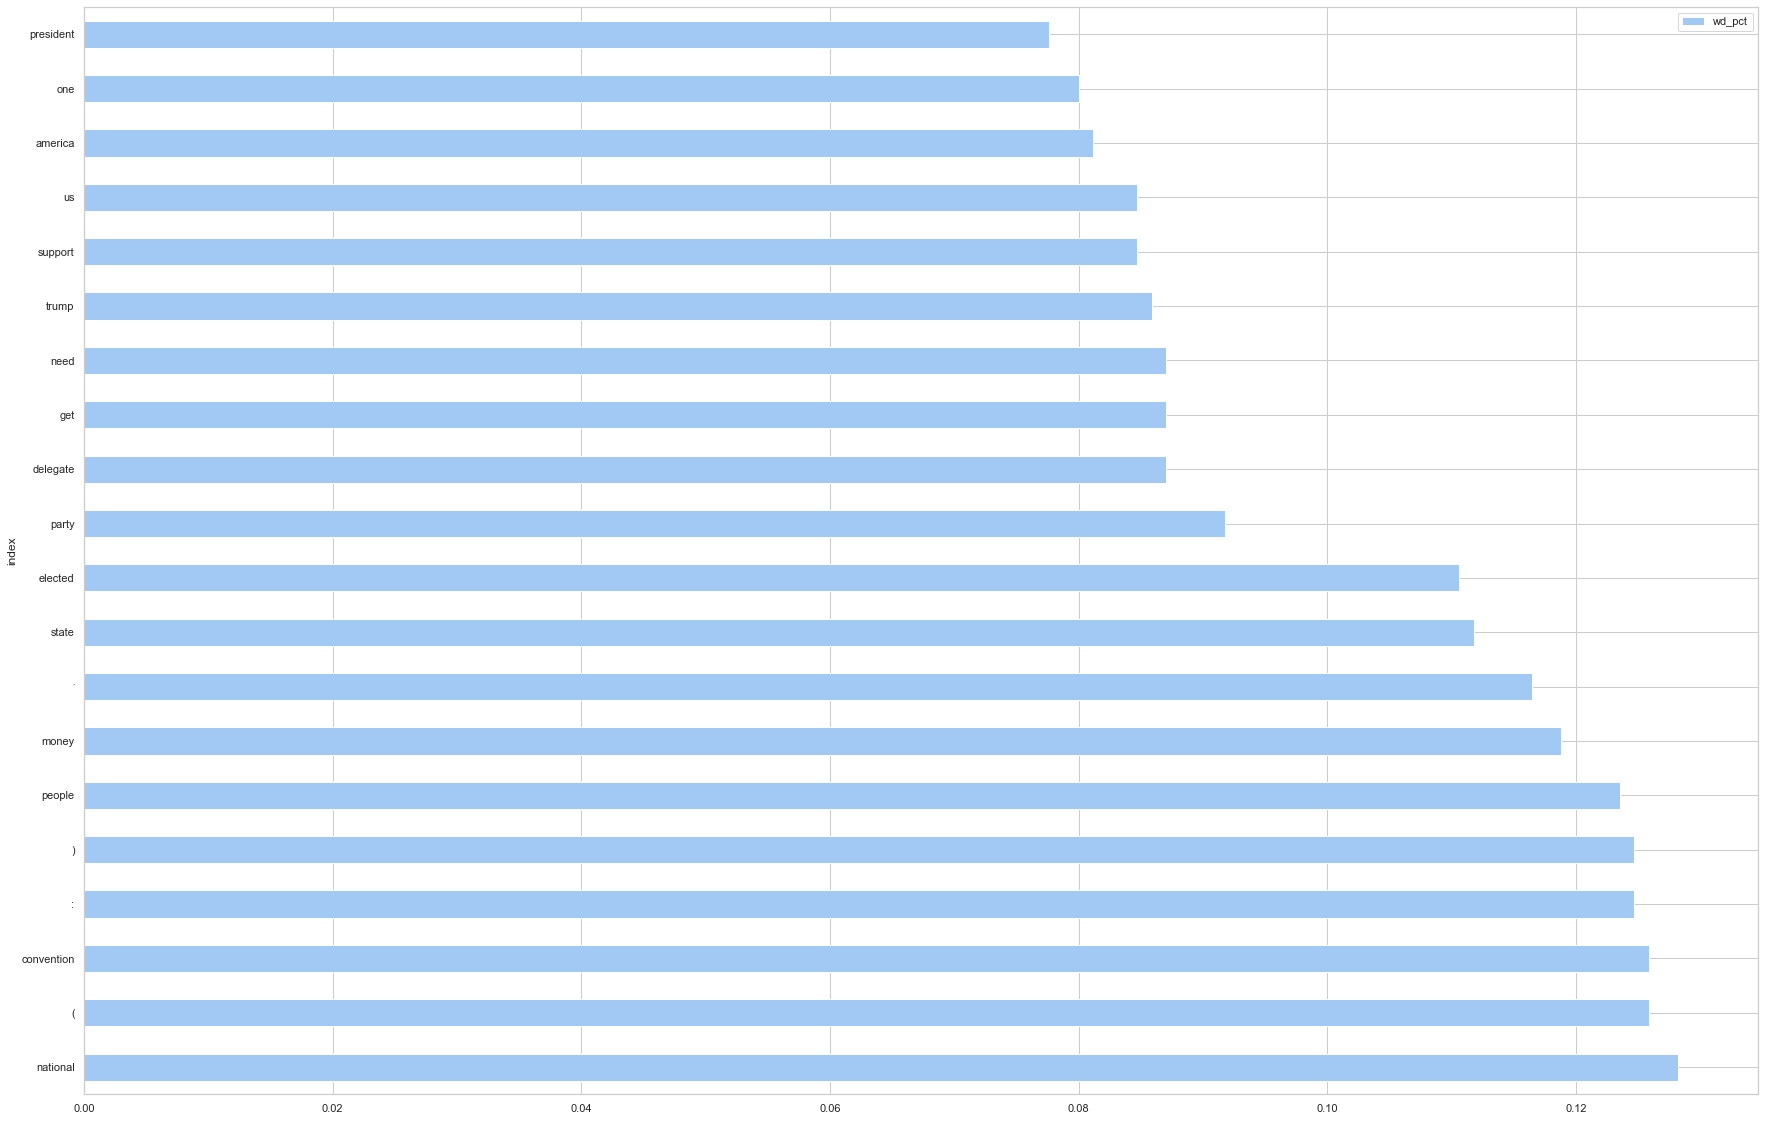

In [258]:
dem_counts.sort_values('wd_pct',ascending=False)[10:30].plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

All frequencies, including STOPWORDS:
           Word  Frequency
0           the       3333
1             ,       2911
2             .       2664
3            to       2615
4           and       2085
5             a       1711
6             i       1697
7            of       1616
8            in       1399
9           ...       1374
10          for       1102
11           is        964
12           my        706
13           we        646
14         this        546
15            !        540
16           on        519
17          our        499
18         that        496
19         have        491
20           as        467
21          are        458
22           am        412
23           be        409
24         will        406
25          was        376
26         with        370
27          you        360
28           it        335
29           's        323
..          ...        ...
470           '         20
471         car         20
472       white         20
473        stop  

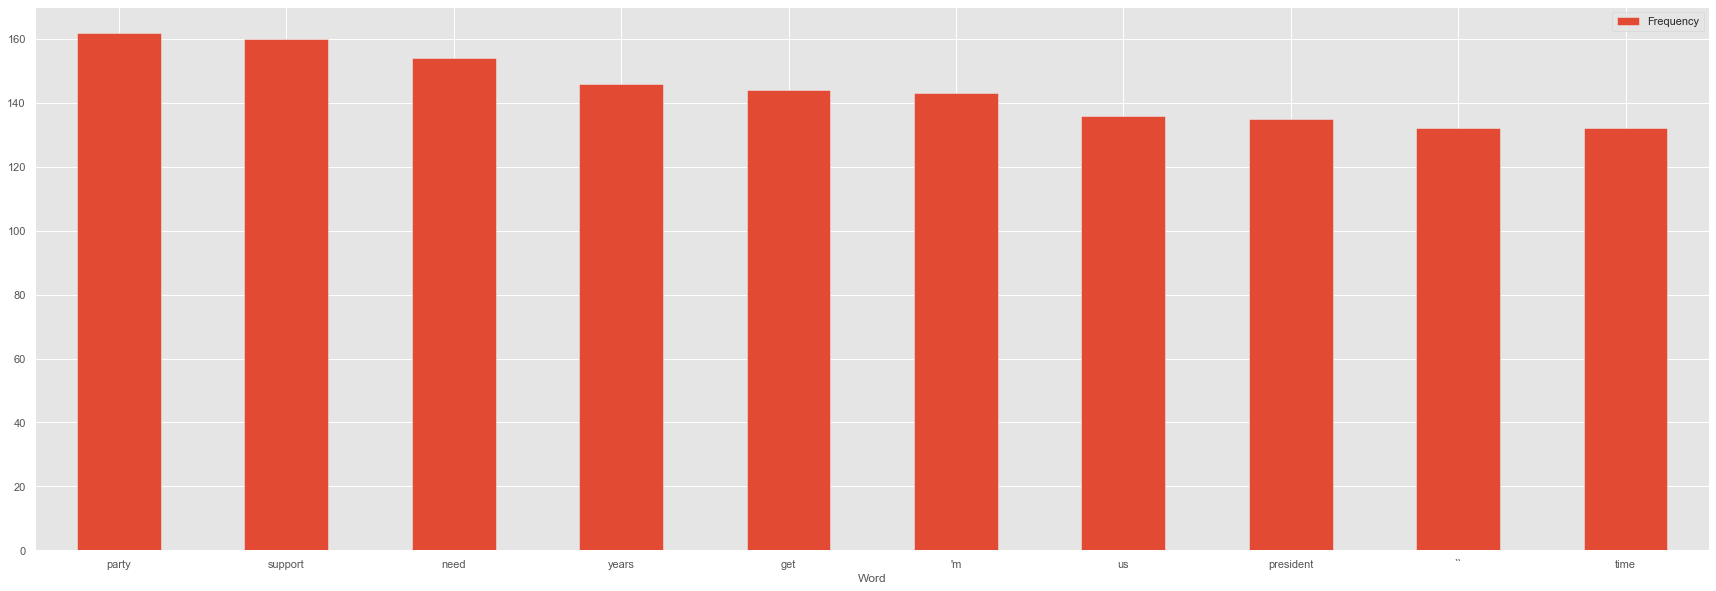

In [21]:
#all words
top_N = 500
txt = df['summary'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
matplotlib.style.use('ggplot')
rslt[20:30].plot.bar(rot=0,figsize=(30,10))

In [261]:
#combinging rep and dem counts dataframs
rep_counts['tag']='rep'
dem_counts['tag']='dem'
words_df=rep_counts.append(dem_counts)
words_df=words_df.reset_index()


/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph

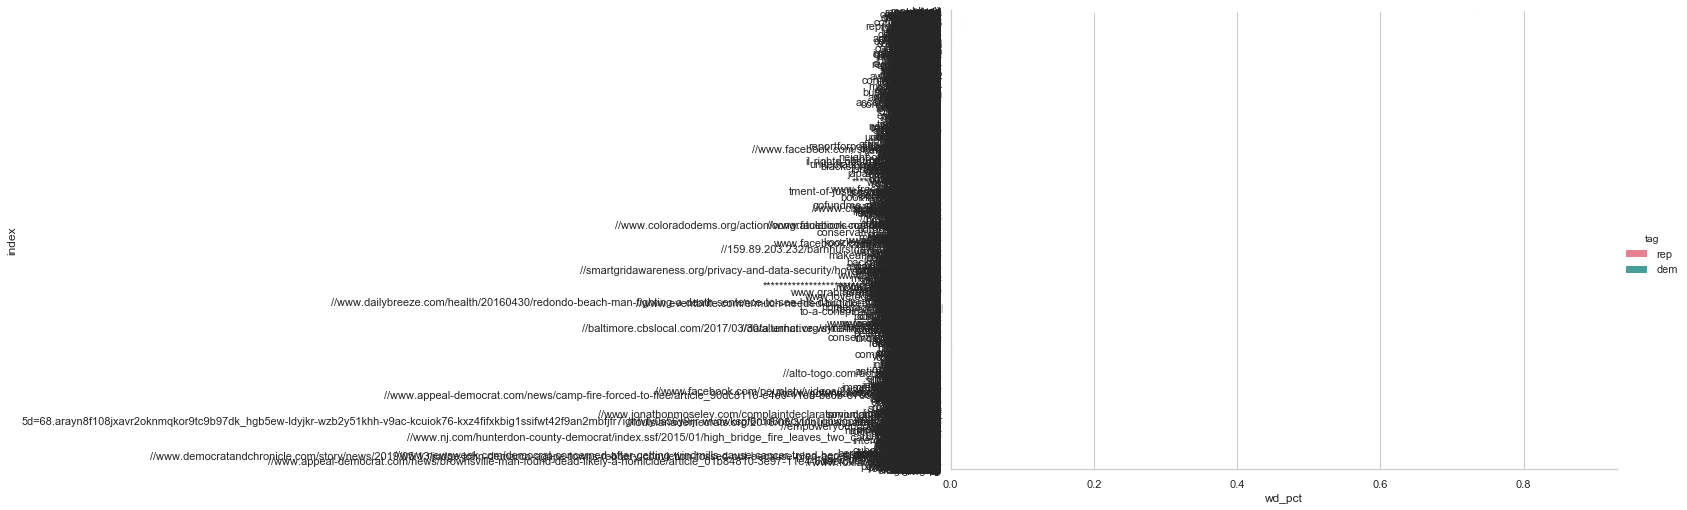

In [268]:
sns.catplot(y="index", x="wd_pct", hue="tag", kind="bar", 
            data=words_df[words_df.index.isin(['.',',','$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [23]:
#ideally, I would bin and graph
rslt=rslt.reset_index()

In [27]:
ser_df=rslt
ser_df=ser_df.rename(columns={'Frequency':'total'})


In [28]:
ser_df.head(3)

,Word,total
0,",",2911
1,.,2664
2,...,1374


In [29]:
words_df=words_df.merge(ser_df,left_on='Word',right_on='Word',how='left')
words_df.head()

,Word,Frequency,tag,wd_pct,total
0,",",1683,rep,0.659741,2911.0
1,.,1571,rep,0.615837,2664.0
2,...,804,rep,0.315171,1374.0
3,!,308,rep,0.120737,540.0
4,republican,273,rep,0.107017,275.0


In [30]:
ser_df[ser_df['Word']=='republican']

,Word,total
6,republican,275


In [31]:
rslt[rslt['Word']=='republican']

,Word,Frequency
6,republican,275


In [32]:
words_df[words_df['Word']=='republican']

,Word,Frequency,tag,wd_pct,total
4,republican,273,rep,0.107017,275.0


In [33]:
ser=words_df.total

In [40]:
words_df['word_bin']=pd.qcut(ser, q=5,labels=['1','2','3','4','5'])

# sns.catplot(kind='bar',x='Frequency',y='Word',hue='tag',row='word_bin',data=words_df,height=20,aspect=2)

In [51]:
#making individual bins because 
words_df_3=words_df[words_df['word_bin']=='3']
words_df_1=words_df[words_df['word_bin']=='1']
words_df_2=words_df[words_df['word_bin']=='2']
words_df_4=words_df[words_df['word_bin']=='4']
words_df_5=words_df[words_df['word_bin']=='5']

In [42]:
words_df_3.Word.unique()

array(['nonetype', 'congress', 'start', '”', 'right', 'raised',
       'presidential', 'story', 'left', 'come', 'governor', 'club', 'ago',
       '#', 'small', 'way', 'long', 'change', 'together', 'week', 'keep',
       'used', 'good', 'group', 'care', 'education', 'city', 'show',
       'media', 'important', 'former', 'around', 'build', 'trying',
       'must', 'law', 'issues', 'fellow', 'bring', 'november', 'friend',
       'continue', 'dear', 'read', '5', 'helping', 'today', 'june',
       'future', 'past', 'voters', 'still', 'part', 'little', 'put',
       'news', 'become', 'cover', 'travel', 'funding', 'lives', 'strong',
       'member', '4', 'ca', 'voting', 'nation', 'page', 'march',
       'facebook', 'liberal', 'ever', 'lost', 'expenses', 'senator',
       'hard', 'away', 'provide', 'getting', 'world', 'send', 'cost',
       'delegates', 'hillary', 'dnc', 'progressive', 'honor', 'upcoming',
       'san'], dtype=object)

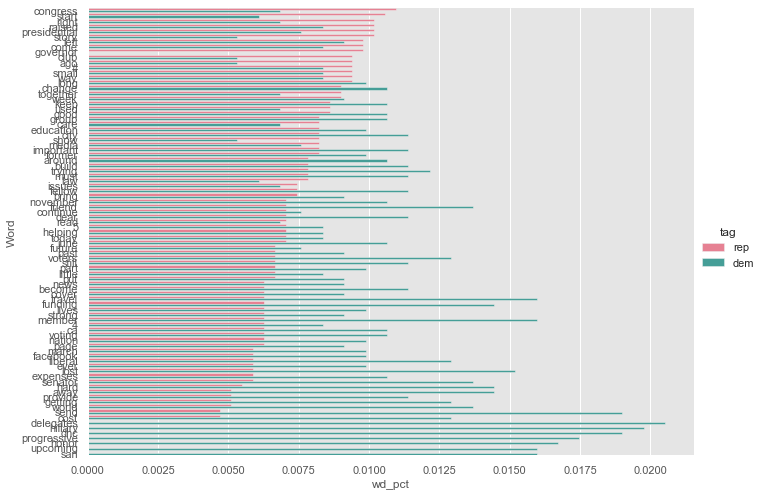

In [48]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_3[words_df_3.Word.isin(['$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [52]:
words_df_5.Word.unique()

array([',', '.', '...', '!', 'republican', "'s", '’', ':', 'help', '(',
       ')', 'trump', 'republicans', 'people', 'money', 'support', 'state',
       'years', 'party', '``', 'name', "''", 'campaign', "'m", 'need',
       'political', 'time', 'president', 'get', 'want', 'family', 'like',
       'would', 'us', '-', '?', 'one', 'many', 'new', 'america',
       'national', 'year', 'college', 'make', 'country', 'county', '$',
       '--', 'school', 'conservative', 'american', 'states', 'democratic',
       'united', 'election', 'please', 'first', 'democrat', 'life', 'go',
       'know', 'running', 'elected', 'great', 'democrats', 'vote', "n't",
       'community', 'raise', 'hello', 'funds', 'hi', 'convention',
       'raising', 'district', 'friends', 'work', 'since', 'young', 'fund',
       'house', 'high', 'delegate', '2016', 'bernie', 'sanders'],
      dtype=object)

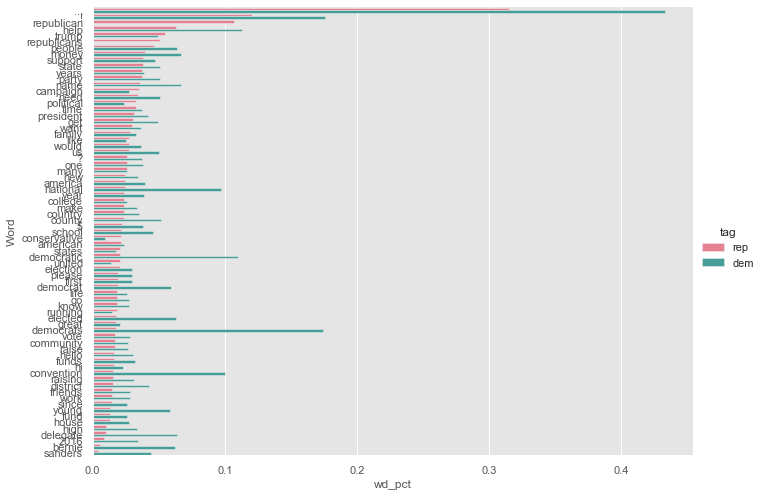

In [54]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_5[words_df_5.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';','(',')',"n't",'--','-'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

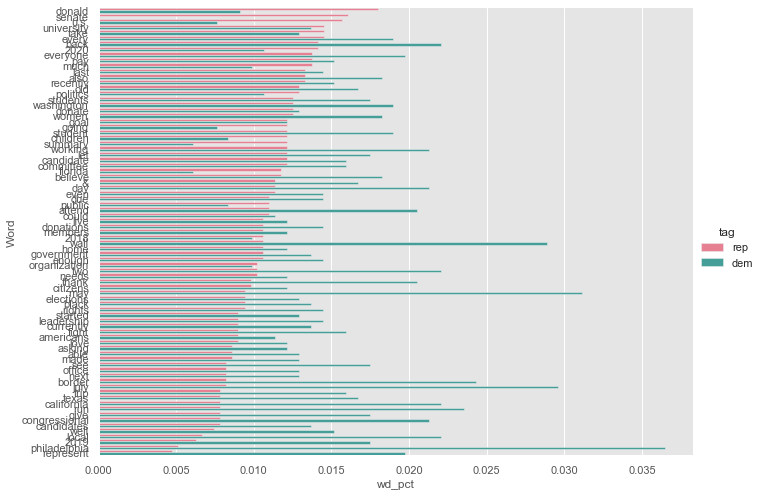

In [50]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_4[words_df_4.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [182]:
ser 